##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Uncertainty-aware Deep Language Learning with BERT-SNGP

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/uncertainty_quantification_with_sngp_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/uncertainty_quantification_with_sngp_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/uncertainty_quantification_with_sngp_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/uncertainty_quantification_with_sngp_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

In the [SNGP tutorial](https://www.tensorflow.org/tutorials/understanding/sngp), you learned how to build SNGP model on top of a deep residual network to improve its ability to quantify its uncertainty. In this tutorial, you will apply SNGP to a natural language understanding (NLU) task by building it on top of a deep BERT encoder to improve deep NLU model's ability in detecting out-of-scope queries. 

Specifically, you will:
* Build BERT-SNGP, a SNGP-augmented [BERT](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) model.
* Load the [CLINC Out-of-scope (OOS)](https://www.tensorflow.org/datasets/catalog/clinc_oos) intent detection dataset.
* Train the BERT-SNGP model.
* Evaluate the BERT-SNGP model's performance in uncertainty calibration and out-of-domain detection.

Beyond CLINC OOS, the SNGP model has been applied to large-scale datasets such as [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), and to the image datasets such as [CIFAR-100](https://www.tensorflow.org/datasets/catalog/cifar100) and [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012). 
For benchmark results of SNGP and other uncertainty methods, as well as high-quality implementation with end-to-end training / evaluation scripts, you can check out the [Uncertainty Baselines](https://github.com/google/uncertainty-baselines) benchmark.

## Setup

In [2]:
!pip uninstall -y tensorflow tf-text

Found existing installation: tensorflow 2.6.0


Uninstalling tensorflow-2.6.0:


  Successfully uninstalled tensorflow-2.6.0


In [3]:
!pip install -U tensorflow-text-nightly

     |▌                               | 61 kB 4.2 MB/s eta 0:00:02

     |██████▊                         | 911 kB 3.7 MB/s eta 0:00:01

     |████████████████████████████████| 4.3 MB 3.7 MB/s eta 0:00:01

     |████████████████████████████████| 4.3 MB 3.7 MB/s 


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install -U tf-nightly

     |                                | 81 kB 4.7 MB/s eta 0:01:40

     |                                | 1.5 MB 3.9 MB/s eta 0:01:59

     |▍                               | 5.2 MB 3.9 MB/s eta 0:01:58

     |▋                               | 9.5 MB 3.9 MB/s eta 0:01:57

     |█▍                              | 20.2 MB 3.9 MB/s eta 0:01:54

     |█▊                              | 25.6 MB 3.9 MB/s eta 0:01:53

     |██▏                             | 31.0 MB 3.9 MB/s eta 0:01:52

     |██▌                             | 36.1 MB 3.9 MB/s eta 0:01:50

     |██▊                             | 40.6 MB 3.9 MB/s eta 0:01:49

     |███                             | 45.5 MB 3.9 MB/s eta 0:01:48

     |███▌                            | 50.9 MB 3.9 MB/s eta 0:01:47

     |███▉                            | 56.4 MB 3.9 MB/s eta 0:01:45

     |████▎                           | 61.9 MB 3.9 MB/s eta 0:01:44

     |████▋                           | 67.3 MB 3.9 MB/s eta 0:01:42

     |█████                           | 72.7 MB 3.9 MB/s eta 0:01:41

     |█████▍                          | 78.2 MB 3.9 MB/s eta 0:01:40

     |█████▊                          | 83.0 MB 3.9 MB/s eta 0:01:38

     |██████                          | 88.5 MB 3.9 MB/s eta 0:01:37

     |██████▍                         | 93.7 MB 3.9 MB/s eta 0:01:36

     |██████▊                         | 99.0 MB 97.4 MB/s eta 0:00:04

     |███████▏                        | 104.3 MB 97.4 MB/s eta 0:00:04

     |███████▌                        | 109.7 MB 97.4 MB/s eta 0:00:04

     |███████▉                        | 114.7 MB 97.4 MB/s eta 0:00:04

     |████████▏                       | 119.8 MB 97.4 MB/s eta 0:00:04

     |████████▌                       | 125.0 MB 97.4 MB/s eta 0:00:04

     |█████████                       | 130.2 MB 97.4 MB/s eta 0:00:04

     |█████████▎                      | 135.3 MB 97.4 MB/s eta 0:00:04

     |█████████▋                      | 140.5 MB 97.4 MB/s eta 0:00:04

     |██████████                      | 145.9 MB 97.4 MB/s eta 0:00:04

     |██████████▍                     | 151.4 MB 97.4 MB/s eta 0:00:04

     |██████████▊                     | 156.9 MB 97.4 MB/s eta 0:00:04

     |███████████                     | 162.3 MB 97.4 MB/s eta 0:00:04

     |███████████▌                    | 167.8 MB 97.4 MB/s eta 0:00:04

     |███████████▉                    | 173.0 MB 97.4 MB/s eta 0:00:04

     |████████████▏                   | 178.4 MB 97.4 MB/s eta 0:00:03

     |████████████▋                   | 183.8 MB 97.4 MB/s eta 0:00:03

     |█████████████                   | 189.0 MB 97.4 MB/s eta 0:00:03

     |█████████████▎                  | 194.4 MB 97.4 MB/s eta 0:00:03

     |█████████████▋                  | 199.9 MB 102.0 MB/s eta 0:00:03

     |██████████████                  | 203.4 MB 102.0 MB/s eta 0:00:03

     |██████████████▏                 | 207.1 MB 102.0 MB/s eta 0:00:03

     |██████████████▍                 | 210.8 MB 102.0 MB/s eta 0:00:03

     |██████████████▊                 | 215.4 MB 102.0 MB/s eta 0:00:03

     |███████████████                 | 221.0 MB 102.0 MB/s eta 0:00:03

     |███████████████▌                | 226.4 MB 102.0 MB/s eta 0:00:03

     |███████████████▉                | 231.8 MB 102.0 MB/s eta 0:00:03

     |████████████████▏               | 237.2 MB 102.0 MB/s eta 0:00:03

     |████████████████▋               | 242.5 MB 102.0 MB/s eta 0:00:03

     |█████████████████               | 248.0 MB 102.0 MB/s eta 0:00:03

     |█████████████████▎              | 253.3 MB 102.0 MB/s eta 0:00:03

     |█████████████████▋              | 258.4 MB 102.0 MB/s eta 0:00:03

     |██████████████████              | 263.8 MB 102.0 MB/s eta 0:00:03

     |██████████████████▍             | 269.2 MB 102.0 MB/s eta 0:00:02

     |██████████████████▊             | 274.6 MB 102.0 MB/s eta 0:00:02

     |███████████████████▏            | 279.9 MB 102.0 MB/s eta 0:00:02

     |███████████████████▌            | 285.2 MB 102.0 MB/s eta 0:00:02

     |███████████████████▉            | 290.0 MB 102.0 MB/s eta 0:00:02

     |████████████████████▏           | 295.3 MB 102.0 MB/s eta 0:00:02

     |████████████████████▌           | 300.7 MB 113.9 MB/s eta 0:00:02

     |█████████████████████           | 306.0 MB 113.9 MB/s eta 0:00:02

     |█████████████████████▎          | 311.2 MB 113.9 MB/s eta 0:00:02

     |█████████████████████▋          | 316.6 MB 113.9 MB/s eta 0:00:02

     |██████████████████████          | 322.0 MB 113.9 MB/s eta 0:00:02

     |██████████████████████▍         | 327.2 MB 113.9 MB/s eta 0:00:02

     |██████████████████████▊         | 332.1 MB 113.9 MB/s eta 0:00:02

     |███████████████████████         | 337.0 MB 113.9 MB/s eta 0:00:02

     |███████████████████████▍        | 342.3 MB 113.9 MB/s eta 0:00:02

     |███████████████████████▊        | 347.2 MB 113.9 MB/s eta 0:00:02

     |████████████████████████        | 352.5 MB 113.9 MB/s eta 0:00:02

     |████████████████████████▍       | 356.9 MB 113.9 MB/s eta 0:00:01

     |████████████████████████▊       | 361.1 MB 113.9 MB/s eta 0:00:01

     |█████████████████████████       | 365.6 MB 113.9 MB/s eta 0:00:01

     |█████████████████████████▍      | 370.8 MB 113.9 MB/s eta 0:00:01

     |█████████████████████████▋      | 375.4 MB 113.9 MB/s eta 0:00:01

     |██████████████████████████      | 380.6 MB 113.9 MB/s eta 0:00:01

     |██████████████████████████▍     | 385.9 MB 113.9 MB/s eta 0:00:01

     |██████████████████████████▊     | 391.3 MB 113.9 MB/s eta 0:00:01

     |███████████████████████████▏    | 396.8 MB 118.9 MB/s eta 0:00:01

     |███████████████████████████▌    | 402.1 MB 118.9 MB/s eta 0:00:01

     |███████████████████████████▉    | 407.4 MB 118.9 MB/s eta 0:00:01

     |████████████████████████████▏   | 412.6 MB 118.9 MB/s eta 0:00:01

     |████████████████████████████▌   | 417.9 MB 118.9 MB/s eta 0:00:01

     |█████████████████████████████   | 423.2 MB 118.9 MB/s eta 0:00:01

     |█████████████████████████████▎  | 428.7 MB 118.9 MB/s eta 0:00:01

     |█████████████████████████████▋  | 433.7 MB 118.9 MB/s eta 0:00:01

     |██████████████████████████████  | 437.7 MB 118.9 MB/s eta 0:00:01

     |██████████████████████████████▏ | 441.5 MB 118.9 MB/s eta 0:00:01

     |██████████████████████████████▍ | 445.5 MB 118.9 MB/s eta 0:00:01

     |██████████████████████████████▉ | 450.7 MB 118.9 MB/s eta 0:00:01

     |███████████████████████████████▏| 455.9 MB 118.9 MB/s eta 0:00:01

     |███████████████████████████████▌| 461.1 MB 118.9 MB/s eta 0:00:01

     |███████████████████████████████▉| 466.5 MB 118.9 MB/s eta 0:00:01

     |████████████████████████████████| 468.4 MB 118.9 MB/s eta 0:00:01

     |████████████████████████████████| 468.4 MB 11 kB/s 


     |███████▋                        | 3.0 MB 20.1 MB/s eta 0:00:01

     |█████████████████████           | 8.4 MB 20.1 MB/s eta 0:00:01

     |████████████████████████████████| 12.8 MB 20.1 MB/s eta 0:00:01

     |████████████████████████████████| 12.8 MB 20.1 MB/s 


     |████████████████████████████████| 463 kB 89.7 MB/s 


     |▌                               | 81 kB 40.1 MB/s eta 0:00:01

     |███████████████████████████████▏| 5.6 MB 41.0 MB/s eta 0:00:01

     |████████████████████████████████| 5.7 MB 41.0 MB/s 


     |█████████████▎                  | 552 kB 63.5 MB/s eta 0:00:01

     |████████████████████████████████| 1.3 MB 63.5 MB/s 


     |█████████████████▍              | 1.2 MB 40.3 MB/s eta 0:00:01

     |████████████████████████████████| 2.3 MB 40.3 MB/s 


  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install -U tf-models-nightly

     |█▌                              | 81 kB 4.7 MB/s eta 0:00:01

     |███████████████████████████▌    | 1.5 MB 3.9 MB/s eta 0:00:01

     |████████████████████████████████| 1.8 MB 3.9 MB/s 


     |████████████████████████████████| 99 kB 15.0 MB/s 


     |████████████████████████████████| 43 kB 3.3 MB/s 


     |████████████████████████████████| 1.1 MB 85.2 MB/s 


     |████████████████████████████████| 211 kB 97.5 MB/s 


     |███▊                            | 860 kB 69.3 MB/s eta 0:00:01

     |███████████████████████         | 5.3 MB 69.3 MB/s eta 0:00:01

     |████████████████████████████████| 7.4 MB 69.3 MB/s eta 0:00:01

     |████████████████████████████████| 7.4 MB 69.3 MB/s 


     |████▏                           | 4.8 MB 85.5 MB/s eta 0:00:01

     |█████████                       | 10.5 MB 85.5 MB/s eta 0:00:01

     |██████████████▌                 | 16.8 MB 85.5 MB/s eta 0:00:01

     |███████████████████▉            | 23.1 MB 85.5 MB/s eta 0:00:01

     |█████████████████████████       | 29.0 MB 85.5 MB/s eta 0:00:01

     |██████████████████████████████  | 34.9 MB 85.5 MB/s eta 0:00:01

     |████████████████████████████████| 37.1 MB 85.5 MB/s eta 0:00:01

     |████████████████████████████████| 37.1 MB 85.5 MB/s 


     |████████████████████████████████| 58 kB 10.1 MB/s 


     |████████████████████████████████| 98 kB 12.2 MB/s 


     |████████████████████████████████| 1.2 MB 92.7 MB/s 


     |████████████████████████████████| 352 kB 94.7 MB/s 


  Using cached Cython-0.29.24-cp37-cp37m-manylinux1_x86_64.whl (2.0 MB)


     |████████████████████████████████| 636 kB 89.3 MB/s 


     |████████████████████████████████| 90 kB 12.6 MB/s 


     |████████████████████████████▍   | 40 kB 62.0 MB/s eta 0:00:01

     |████████████████████████████████| 46 kB 6.0 MB/s 


     |████████████████████████████████| 296 kB 90.6 MB/s 


     |███▌                            | 10 kB 31.5 MB/s eta 0:00:01

     |████████████████████████████████| 92 kB 624 kB/s 


     |████████████████████████████████| 95 kB 6.9 MB/s 


     |████████████████████████████████| 93 kB 3.9 MB/s 


     |████████████████████████████████| 78 kB 10.9 MB/s 


     |████████████████████████████████| 747 kB 85.1 MB/s 


 \

 done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=fad349a345dcfe078eb5e44296bb88af9b66c5e57cddcb1e9648d5a34075e95e
  Stored in directory: /home/kbuilder/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5


 done
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=1672b27c5acdbf475f3e9db8ad59ff75f2a56cec2e99c963e7e5a62a9979282d
  Stored in directory: /home/kbuilder/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401


 \

 |

 /

 -

 done
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=264011 sha256=bebd5a5792043f97adeaf0d32945a1bf84675e859a0d8f7db2d355092f2358e9
  Stored in directory: /home/kbuilder/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf


 done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=5b5cb9bf702b8e5658e43806b1f94f9546b633a0f26addf104641f69648cabf7
  Stored in directory: /home/kbuilder/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7


Successfully built kaggle py-cpuinfo pycocotools seqeval


  Attempting uninstall: httplib2
    Found existing installation: httplib2 0.9.2
    Not uninstalling httplib2 at /usr/lib/python3/dist-packages, outside environment /tmpfs/src/tf_docs_env
    Can't uninstall 'httplib2'. No files were found to uninstall.


  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.12
    Not uninstalling pyyaml at /usr/lib/python3/dist-packages, outside environment /tmpfs/src/tf_docs_env
    Can't uninstall 'PyYAML'. No files were found to uninstall.


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [6]:
import matplotlib.pyplot as plt

import sklearn.metrics
import sklearn.calibration

import tensorflow_hub as hub
import tensorflow_datasets as tfds

import numpy as np
import tensorflow as tf

import official.nlp.modeling.layers as layers
import official.nlp.optimization as optimization

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.7.0-dev20210824). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


This tutorial needs the GPU to run efficiently. Check if the GPU is available. 

In [7]:
tf.__version__

'2.7.0-dev20210824'

In [8]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
assert gpus, """
  No GPU(s) found! This tutorial will take many hours to run without a GPU.

  You may hit this error if the installed tensorflow package is not
  compatible with the CUDA and CUDNN versions."""

First implement a standard BERT classifier following the [classify text with BERT](https://www.tensorflow.org/tutorials/text/classify_text_with_bert) tutorial. We will use the [BERT-base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) encoder, and the built-in [`ClassificationHead`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/cls_head.py) as the classifier.

In [10]:
#@title Standard BERT model

PREPROCESS_HANDLE = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
MODEL_HANDLE = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'

class BertClassifier(tf.keras.Model):
  def __init__(self, 
               num_classes=150, inner_dim=768, dropout_rate=0.1,
               **classifier_kwargs):
    
    super().__init__()
    self.classifier_kwargs = classifier_kwargs

    # Initiate the BERT encoder components.
    self.bert_preprocessor = hub.KerasLayer(PREPROCESS_HANDLE, name='preprocessing')
    self.bert_hidden_layer = hub.KerasLayer(MODEL_HANDLE, trainable=True, name='bert_encoder')

    # Defines the encoder and classification layers.
    self.bert_encoder = self.make_bert_encoder()
    self.classifier = self.make_classification_head(num_classes, inner_dim, dropout_rate)

  def make_bert_encoder(self):
    text_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = self.bert_preprocessor(text_inputs)
    encoder_outputs = self.bert_hidden_layer(encoder_inputs)
    return tf.keras.Model(text_inputs, encoder_outputs)

  def make_classification_head(self, num_classes, inner_dim, dropout_rate):
    return layers.ClassificationHead(
        num_classes=num_classes, 
        inner_dim=inner_dim,
        dropout_rate=dropout_rate,
        **self.classifier_kwargs)

  def call(self, inputs, **kwargs):
    encoder_outputs = self.bert_encoder(inputs)
    classifier_inputs = encoder_outputs['sequence_output']
    return self.classifier(classifier_inputs, **kwargs)


### Build SNGP model

To implement a BERT-SNGP model, you only need to replace the `ClassificationHead` with the built-in [`GaussianProcessClassificationHead`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/cls_head.py). Spectral normalization is already pre-packaged into this classification head. Like in the [SNGP tutorial](https://www.tensorflow.org/tutorials/uncertainty/sngp), add a covariance reset callback to the model, so the model automatically reset the covariance estimator at the begining of a new epoch to avoid counting the same data twice.

In [11]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the begining of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [12]:
class SNGPBertClassifier(BertClassifier):

  def make_classification_head(self, num_classes, inner_dim, dropout_rate):
    return layers.GaussianProcessClassificationHead(
        num_classes=num_classes, 
        inner_dim=inner_dim,
        dropout_rate=dropout_rate,
        gp_cov_momentum=-1,
        temperature=30.,
        **self.classifier_kwargs)

  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs['callbacks'] = list(kwargs.get('callbacks', []))
    kwargs['callbacks'].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)

Note: The `GaussianProcessClassificationHead` takes a new argument `temperature`. It corresponds to the $\lambda$ parameter in the __mean-field approximation__ introduced in the [SNGP tutorial](https://www.tensorflow.org/tutorials/uncertainty/sngp). In practice, this value is usually treated as a hyperparamter, and is finetuned to optimize the model's calibration performance.

### Load CLINC OOS dataset

Now load the [CLINC OOS](https://www.tensorflow.org/datasets/catalog/clinc_oos) intent detection dataset. This dataset contains 15000 user's spoken queries collected over 150 intent classes, it also contains 1000 out-of-domain (OOD) sentences that are not covered by any of the known classes.

In [13]:
(clinc_train, clinc_test, clinc_test_oos), ds_info = tfds.load(
    'clinc_oos', split=['train', 'test', 'test_oos'], with_info=True, batch_size=-1)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Make the train and test data.

In [14]:
train_examples = clinc_train['text']
train_labels = clinc_train['intent']

# Makes the in-domain (IND) evaluation data.
ind_eval_data = (clinc_test['text'], clinc_test['intent'])

Create a OOD evaluation dataset. For this, combine the in-domain test data `clinc_test` and the out-of-domain data `clinc_test_oos`. We will also assign label 0 to the in-domain examples, and label 1 to the out-of-domain examples. 

In [15]:
test_data_size = ds_info.splits['test'].num_examples
oos_data_size = ds_info.splits['test_oos'].num_examples

# Combines the in-domain and out-of-domain test examples.
oos_texts = tf.concat([clinc_test['text'], clinc_test_oos['text']], axis=0)
oos_labels = tf.constant([0] * test_data_size + [1] * oos_data_size)

# Converts into a TF dataset.
ood_eval_dataset = tf.data.Dataset.from_tensor_slices(
    {"text": oos_texts, "label": oos_labels})

### Train and evaluate

First set up the basic training configurations.

In [16]:
TRAIN_EPOCHS = 3
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 256

In [17]:
#@title

def bert_optimizer(learning_rate, 
                   batch_size=TRAIN_BATCH_SIZE, epochs=TRAIN_EPOCHS, 
                   warmup_rate=0.1):
  """Creates an AdamWeightDecay optimizer with learning rate schedule."""
  train_data_size = ds_info.splits['train'].num_examples
  
  steps_per_epoch = int(train_data_size / batch_size)
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(warmup_rate * num_train_steps)  

  # Creates learning schedule.
  lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=learning_rate,
      decay_steps=num_train_steps,
      end_learning_rate=0.0)  
  
  return optimization.AdamWeightDecay(
      learning_rate=lr_schedule,
      weight_decay_rate=0.01,
      epsilon=1e-6,
      exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])

In [18]:
optimizer = bert_optimizer(learning_rate=1e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()

In [19]:
fit_configs = dict(batch_size=TRAIN_BATCH_SIZE,
                   epochs=TRAIN_EPOCHS,
                   validation_batch_size=EVAL_BATCH_SIZE, 
                   validation_data=ind_eval_data)

In [20]:
sngp_model = SNGPBertClassifier()
sngp_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
sngp_model.fit(train_examples, train_labels, **fit_configs)

Epoch 1/3


  1/469 [..............................] - ETA: 2:39:45 - loss: 5.4468 - sparse_categorical_accuracy: 0.0000e+00

  2/469 [..............................] - ETA: 2:32 - loss: 5.2522 - sparse_categorical_accuracy: 0.0000e+00   

  3/469 [..............................] - ETA: 2:32 - loss: 5.3976 - sparse_categorical_accuracy: 0.0000e+00

  4/469 [..............................] - ETA: 2:32 - loss: 5.3334 - sparse_categorical_accuracy: 0.0078    

  5/469 [..............................] - ETA: 2:31 - loss: 5.3467 - sparse_categorical_accuracy: 0.0063

  6/469 [..............................] - ETA: 2:31 - loss: 5.3107 - sparse_categorical_accuracy: 0.0052

  7/469 [..............................] - ETA: 2:31 - loss: 5.2889 - sparse_categorical_accuracy: 0.0089

  8/469 [..............................] - ETA: 2:31 - loss: 5.2836 - sparse_categorical_accuracy: 0.0078

  9/469 [..............................] - ETA: 2:30 - loss: 5.2722 - sparse_categorical_accuracy: 0.0069

 10/469 [..............................] - ETA: 2:30 - loss: 5.2763 - sparse_categorical_accuracy: 0.0063

 11/469 [..............................] - ETA: 2:29 - loss: 5.2974 - sparse_categorical_accuracy: 0.0057

 12/469 [..............................] - ETA: 2:29 - loss: 5.2639 - sparse_categorical_accuracy: 0.0052

 13/469 [..............................] - ETA: 2:28 - loss: 5.2713 - sparse_categorical_accuracy: 0.0048

 14/469 [..............................] - ETA: 2:28 - loss: 5.2648 - sparse_categorical_accuracy: 0.0067

 15/469 [..............................] - ETA: 2:28 - loss: 5.2570 - sparse_categorical_accuracy: 0.0104

 16/469 [>.............................] - ETA: 2:27 - loss: 5.2445 - sparse_categorical_accuracy: 0.0098

 17/469 [>.............................] - ETA: 2:27 - loss: 5.2403 - sparse_categorical_accuracy: 0.0110

 18/469 [>.............................] - ETA: 2:27 - loss: 5.2285 - sparse_categorical_accuracy: 0.0104

 19/469 [>.............................] - ETA: 2:27 - loss: 5.2221 - sparse_categorical_accuracy: 0.0099

 20/469 [>.............................] - ETA: 2:26 - loss: 5.2005 - sparse_categorical_accuracy: 0.0109

 21/469 [>.............................] - ETA: 2:26 - loss: 5.1951 - sparse_categorical_accuracy: 0.0134

 22/469 [>.............................] - ETA: 2:25 - loss: 5.1799 - sparse_categorical_accuracy: 0.0156

 23/469 [>.............................] - ETA: 2:25 - loss: 5.1541 - sparse_categorical_accuracy: 0.0231

 24/469 [>.............................] - ETA: 2:25 - loss: 5.1352 - sparse_categorical_accuracy: 0.0260

 25/469 [>.............................] - ETA: 2:25 - loss: 5.1222 - sparse_categorical_accuracy: 0.0275

 26/469 [>.............................] - ETA: 2:24 - loss: 5.1188 - sparse_categorical_accuracy: 0.0264

 27/469 [>.............................] - ETA: 2:24 - loss: 5.1025 - sparse_categorical_accuracy: 0.0278

 28/469 [>.............................] - ETA: 2:24 - loss: 5.0918 - sparse_categorical_accuracy: 0.0290

 29/469 [>.............................] - ETA: 2:23 - loss: 5.0752 - sparse_categorical_accuracy: 0.0302

 30/469 [>.............................] - ETA: 2:23 - loss: 5.0600 - sparse_categorical_accuracy: 0.0323

 31/469 [>.............................] - ETA: 2:23 - loss: 5.0509 - sparse_categorical_accuracy: 0.0343

 32/469 [=>............................] - ETA: 2:22 - loss: 5.0351 - sparse_categorical_accuracy: 0.0361

 33/469 [=>............................] - ETA: 2:22 - loss: 5.0162 - sparse_categorical_accuracy: 0.0407

 34/469 [=>............................] - ETA: 2:22 - loss: 5.0021 - sparse_categorical_accuracy: 0.0432

 35/469 [=>............................] - ETA: 2:21 - loss: 4.9950 - sparse_categorical_accuracy: 0.0446

 36/469 [=>............................] - ETA: 2:21 - loss: 4.9669 - sparse_categorical_accuracy: 0.0486

 37/469 [=>............................] - ETA: 2:21 - loss: 4.9495 - sparse_categorical_accuracy: 0.0515

 38/469 [=>............................] - ETA: 2:21 - loss: 4.9337 - sparse_categorical_accuracy: 0.0526

 39/469 [=>............................] - ETA: 2:20 - loss: 4.9136 - sparse_categorical_accuracy: 0.0545

 40/469 [=>............................] - ETA: 2:20 - loss: 4.8917 - sparse_categorical_accuracy: 0.0594

 41/469 [=>............................] - ETA: 2:20 - loss: 4.8802 - sparse_categorical_accuracy: 0.0610

 42/469 [=>............................] - ETA: 2:19 - loss: 4.8666 - sparse_categorical_accuracy: 0.0625

 43/469 [=>............................] - ETA: 2:19 - loss: 4.8422 - sparse_categorical_accuracy: 0.0705

 44/469 [=>............................] - ETA: 2:19 - loss: 4.8217 - sparse_categorical_accuracy: 0.0724

 45/469 [=>............................] - ETA: 2:18 - loss: 4.8084 - sparse_categorical_accuracy: 0.0736

 46/469 [=>............................] - ETA: 2:18 - loss: 4.7857 - sparse_categorical_accuracy: 0.0788

 47/469 [==>...........................] - ETA: 2:18 - loss: 4.7764 - sparse_categorical_accuracy: 0.0791

 48/469 [==>...........................] - ETA: 2:17 - loss: 4.7647 - sparse_categorical_accuracy: 0.0807

 49/469 [==>...........................] - ETA: 2:17 - loss: 4.7455 - sparse_categorical_accuracy: 0.0835

 50/469 [==>...........................] - ETA: 2:17 - loss: 4.7219 - sparse_categorical_accuracy: 0.0862

 51/469 [==>...........................] - ETA: 2:16 - loss: 4.7125 - sparse_categorical_accuracy: 0.0864

 52/469 [==>...........................] - ETA: 2:16 - loss: 4.6904 - sparse_categorical_accuracy: 0.0931

 53/469 [==>...........................] - ETA: 2:16 - loss: 4.6669 - sparse_categorical_accuracy: 0.0985

 54/469 [==>...........................] - ETA: 2:15 - loss: 4.6429 - sparse_categorical_accuracy: 0.1030

 55/469 [==>...........................] - ETA: 2:15 - loss: 4.6194 - sparse_categorical_accuracy: 0.1074

 56/469 [==>...........................] - ETA: 2:15 - loss: 4.5999 - sparse_categorical_accuracy: 0.1105

 57/469 [==>...........................] - ETA: 2:14 - loss: 4.5761 - sparse_categorical_accuracy: 0.1157

 58/469 [==>...........................] - ETA: 2:14 - loss: 4.5516 - sparse_categorical_accuracy: 0.1212

 59/469 [==>...........................] - ETA: 2:14 - loss: 4.5323 - sparse_categorical_accuracy: 0.1250

 60/469 [==>...........................] - ETA: 2:13 - loss: 4.5141 - sparse_categorical_accuracy: 0.1286

 61/469 [==>...........................] - ETA: 2:13 - loss: 4.4966 - sparse_categorical_accuracy: 0.1317

 62/469 [==>...........................] - ETA: 2:13 - loss: 4.4825 - sparse_categorical_accuracy: 0.1346

 63/469 [===>..........................] - ETA: 2:12 - loss: 4.4571 - sparse_categorical_accuracy: 0.1374

 64/469 [===>..........................] - ETA: 2:12 - loss: 4.4317 - sparse_categorical_accuracy: 0.1431

 65/469 [===>..........................] - ETA: 2:12 - loss: 4.4141 - sparse_categorical_accuracy: 0.1486

 66/469 [===>..........................] - ETA: 2:11 - loss: 4.3927 - sparse_categorical_accuracy: 0.1525

 67/469 [===>..........................] - ETA: 2:11 - loss: 4.3765 - sparse_categorical_accuracy: 0.1544

 68/469 [===>..........................] - ETA: 2:11 - loss: 4.3538 - sparse_categorical_accuracy: 0.1581

 69/469 [===>..........................] - ETA: 2:10 - loss: 4.3323 - sparse_categorical_accuracy: 0.1626

 70/469 [===>..........................] - ETA: 2:10 - loss: 4.3085 - sparse_categorical_accuracy: 0.1670

 71/469 [===>..........................] - ETA: 2:10 - loss: 4.2859 - sparse_categorical_accuracy: 0.1721

 72/469 [===>..........................] - ETA: 2:09 - loss: 4.2631 - sparse_categorical_accuracy: 0.1753

 73/469 [===>..........................] - ETA: 2:09 - loss: 4.2422 - sparse_categorical_accuracy: 0.1794

 74/469 [===>..........................] - ETA: 2:09 - loss: 4.2160 - sparse_categorical_accuracy: 0.1841

 75/469 [===>..........................] - ETA: 2:08 - loss: 4.2000 - sparse_categorical_accuracy: 0.1858

 76/469 [===>..........................] - ETA: 2:08 - loss: 4.1773 - sparse_categorical_accuracy: 0.1900

 77/469 [===>..........................] - ETA: 2:08 - loss: 4.1564 - sparse_categorical_accuracy: 0.1940

 78/469 [===>..........................] - ETA: 2:07 - loss: 4.1333 - sparse_categorical_accuracy: 0.1995

 79/469 [====>.........................] - ETA: 2:07 - loss: 4.1138 - sparse_categorical_accuracy: 0.2021

 80/469 [====>.........................] - ETA: 2:07 - loss: 4.0863 - sparse_categorical_accuracy: 0.2086

 81/469 [====>.........................] - ETA: 2:07 - loss: 4.0666 - sparse_categorical_accuracy: 0.2126

 82/469 [====>.........................] - ETA: 2:06 - loss: 4.0428 - sparse_categorical_accuracy: 0.2180

 83/469 [====>.........................] - ETA: 2:06 - loss: 4.0241 - sparse_categorical_accuracy: 0.2210

 84/469 [====>.........................] - ETA: 2:06 - loss: 4.0012 - sparse_categorical_accuracy: 0.2251

 85/469 [====>.........................] - ETA: 2:05 - loss: 3.9790 - sparse_categorical_accuracy: 0.2290

 86/469 [====>.........................] - ETA: 2:05 - loss: 3.9543 - sparse_categorical_accuracy: 0.2347

 87/469 [====>.........................] - ETA: 2:05 - loss: 3.9301 - sparse_categorical_accuracy: 0.2396

 88/469 [====>.........................] - ETA: 2:04 - loss: 3.9059 - sparse_categorical_accuracy: 0.2450

 89/469 [====>.........................] - ETA: 2:04 - loss: 3.8845 - sparse_categorical_accuracy: 0.2489

 90/469 [====>.........................] - ETA: 2:04 - loss: 3.8627 - sparse_categorical_accuracy: 0.2535

 91/469 [====>.........................] - ETA: 2:03 - loss: 3.8422 - sparse_categorical_accuracy: 0.2582

 92/469 [====>.........................] - ETA: 2:03 - loss: 3.8141 - sparse_categorical_accuracy: 0.2646

 93/469 [====>.........................] - ETA: 2:03 - loss: 3.7941 - sparse_categorical_accuracy: 0.2688

 94/469 [=====>........................] - ETA: 2:02 - loss: 3.7725 - sparse_categorical_accuracy: 0.2736

 95/469 [=====>........................] - ETA: 2:02 - loss: 3.7482 - sparse_categorical_accuracy: 0.2786

 96/469 [=====>........................] - ETA: 2:02 - loss: 3.7233 - sparse_categorical_accuracy: 0.2845

 97/469 [=====>........................] - ETA: 2:01 - loss: 3.7032 - sparse_categorical_accuracy: 0.2883

 98/469 [=====>........................] - ETA: 2:01 - loss: 3.6807 - sparse_categorical_accuracy: 0.2930

 99/469 [=====>........................] - ETA: 2:01 - loss: 3.6582 - sparse_categorical_accuracy: 0.2980

100/469 [=====>........................] - ETA: 2:00 - loss: 3.6356 - sparse_categorical_accuracy: 0.3019

101/469 [=====>........................] - ETA: 2:00 - loss: 3.6118 - sparse_categorical_accuracy: 0.3063

102/469 [=====>........................] - ETA: 2:00 - loss: 3.5918 - sparse_categorical_accuracy: 0.3104

103/469 [=====>........................] - ETA: 1:59 - loss: 3.5693 - sparse_categorical_accuracy: 0.3146

104/469 [=====>........................] - ETA: 1:59 - loss: 3.5496 - sparse_categorical_accuracy: 0.3182

105/469 [=====>........................] - ETA: 1:59 - loss: 3.5304 - sparse_categorical_accuracy: 0.3217

106/469 [=====>........................] - ETA: 1:58 - loss: 3.5119 - sparse_categorical_accuracy: 0.3249

107/469 [=====>........................] - ETA: 1:58 - loss: 3.4916 - sparse_categorical_accuracy: 0.3286

108/469 [=====>........................] - ETA: 1:58 - loss: 3.4706 - sparse_categorical_accuracy: 0.3330

109/469 [=====>........................] - ETA: 1:57 - loss: 3.4533 - sparse_categorical_accuracy: 0.3366

110/469 [======>.......................] - ETA: 1:57 - loss: 3.4326 - sparse_categorical_accuracy: 0.3409

111/469 [======>.......................] - ETA: 1:57 - loss: 3.4149 - sparse_categorical_accuracy: 0.3443

112/469 [======>.......................] - ETA: 1:56 - loss: 3.4000 - sparse_categorical_accuracy: 0.3479

113/469 [======>.......................] - ETA: 1:56 - loss: 3.3761 - sparse_categorical_accuracy: 0.3532

114/469 [======>.......................] - ETA: 1:56 - loss: 3.3530 - sparse_categorical_accuracy: 0.3586

115/469 [======>.......................] - ETA: 1:55 - loss: 3.3329 - sparse_categorical_accuracy: 0.3628

116/469 [======>.......................] - ETA: 1:55 - loss: 3.3128 - sparse_categorical_accuracy: 0.3664

117/469 [======>.......................] - ETA: 1:55 - loss: 3.2961 - sparse_categorical_accuracy: 0.3691

118/469 [======>.......................] - ETA: 1:54 - loss: 3.2769 - sparse_categorical_accuracy: 0.3726

119/469 [======>.......................] - ETA: 1:54 - loss: 3.2573 - sparse_categorical_accuracy: 0.3763

120/469 [======>.......................] - ETA: 1:54 - loss: 3.2416 - sparse_categorical_accuracy: 0.3794

121/469 [======>.......................] - ETA: 1:53 - loss: 3.2240 - sparse_categorical_accuracy: 0.3833

122/469 [======>.......................] - ETA: 1:53 - loss: 3.2061 - sparse_categorical_accuracy: 0.3870

123/469 [======>.......................] - ETA: 1:53 - loss: 3.1885 - sparse_categorical_accuracy: 0.3902

124/469 [======>.......................] - ETA: 1:52 - loss: 3.1686 - sparse_categorical_accuracy: 0.3942

125/469 [======>.......................] - ETA: 1:52 - loss: 3.1508 - sparse_categorical_accuracy: 0.3977

126/469 [=======>......................] - ETA: 1:52 - loss: 3.1345 - sparse_categorical_accuracy: 0.4013

127/469 [=======>......................] - ETA: 1:51 - loss: 3.1166 - sparse_categorical_accuracy: 0.4045

128/469 [=======>......................] - ETA: 1:51 - loss: 3.1000 - sparse_categorical_accuracy: 0.4077

129/469 [=======>......................] - ETA: 1:51 - loss: 3.0835 - sparse_categorical_accuracy: 0.4106

130/469 [=======>......................] - ETA: 1:51 - loss: 3.0680 - sparse_categorical_accuracy: 0.4132

131/469 [=======>......................] - ETA: 1:50 - loss: 3.0499 - sparse_categorical_accuracy: 0.4170

132/469 [=======>......................] - ETA: 1:50 - loss: 3.0345 - sparse_categorical_accuracy: 0.4202

133/469 [=======>......................] - ETA: 1:50 - loss: 3.0161 - sparse_categorical_accuracy: 0.4241

134/469 [=======>......................] - ETA: 1:49 - loss: 3.0005 - sparse_categorical_accuracy: 0.4265

135/469 [=======>......................] - ETA: 1:49 - loss: 2.9834 - sparse_categorical_accuracy: 0.4296

136/469 [=======>......................] - ETA: 1:49 - loss: 2.9674 - sparse_categorical_accuracy: 0.4324

137/469 [=======>......................] - ETA: 1:48 - loss: 2.9532 - sparse_categorical_accuracy: 0.4354

138/469 [=======>......................] - ETA: 1:48 - loss: 2.9393 - sparse_categorical_accuracy: 0.4375

139/469 [=======>......................] - ETA: 1:48 - loss: 2.9235 - sparse_categorical_accuracy: 0.4404

140/469 [=======>......................] - ETA: 1:47 - loss: 2.9098 - sparse_categorical_accuracy: 0.4429

141/469 [========>.....................] - ETA: 1:47 - loss: 2.8957 - sparse_categorical_accuracy: 0.4457

142/469 [========>.....................] - ETA: 1:47 - loss: 2.8808 - sparse_categorical_accuracy: 0.4485

143/469 [========>.....................] - ETA: 1:46 - loss: 2.8652 - sparse_categorical_accuracy: 0.4517

144/469 [========>.....................] - ETA: 1:46 - loss: 2.8511 - sparse_categorical_accuracy: 0.4544

145/469 [========>.....................] - ETA: 1:46 - loss: 2.8359 - sparse_categorical_accuracy: 0.4575

146/469 [========>.....................] - ETA: 1:45 - loss: 2.8220 - sparse_categorical_accuracy: 0.4604

147/469 [========>.....................] - ETA: 1:45 - loss: 2.8103 - sparse_categorical_accuracy: 0.4628

148/469 [========>.....................] - ETA: 1:45 - loss: 2.7957 - sparse_categorical_accuracy: 0.4654

149/469 [========>.....................] - ETA: 1:44 - loss: 2.7806 - sparse_categorical_accuracy: 0.4679

150/469 [========>.....................] - ETA: 1:44 - loss: 2.7665 - sparse_categorical_accuracy: 0.4706

151/469 [========>.....................] - ETA: 1:44 - loss: 2.7517 - sparse_categorical_accuracy: 0.4733

152/469 [========>.....................] - ETA: 1:43 - loss: 2.7374 - sparse_categorical_accuracy: 0.4764

153/469 [========>.....................] - ETA: 1:43 - loss: 2.7235 - sparse_categorical_accuracy: 0.4790

154/469 [========>.....................] - ETA: 1:43 - loss: 2.7104 - sparse_categorical_accuracy: 0.4815

155/469 [========>.....................] - ETA: 1:42 - loss: 2.6975 - sparse_categorical_accuracy: 0.4843

156/469 [========>.....................] - ETA: 1:42 - loss: 2.6863 - sparse_categorical_accuracy: 0.4862

157/469 [=========>....................] - ETA: 1:42 - loss: 2.6714 - sparse_categorical_accuracy: 0.4891

158/469 [=========>....................] - ETA: 1:41 - loss: 2.6579 - sparse_categorical_accuracy: 0.4921

159/469 [=========>....................] - ETA: 1:41 - loss: 2.6443 - sparse_categorical_accuracy: 0.4947

160/469 [=========>....................] - ETA: 1:41 - loss: 2.6325 - sparse_categorical_accuracy: 0.4963

161/469 [=========>....................] - ETA: 1:40 - loss: 2.6194 - sparse_categorical_accuracy: 0.4990

162/469 [=========>....................] - ETA: 1:40 - loss: 2.6066 - sparse_categorical_accuracy: 0.5014

163/469 [=========>....................] - ETA: 1:40 - loss: 2.5946 - sparse_categorical_accuracy: 0.5033

164/469 [=========>....................] - ETA: 1:39 - loss: 2.5830 - sparse_categorical_accuracy: 0.5055

165/469 [=========>....................] - ETA: 1:39 - loss: 2.5706 - sparse_categorical_accuracy: 0.5080

166/469 [=========>....................] - ETA: 1:39 - loss: 2.5600 - sparse_categorical_accuracy: 0.5098

167/469 [=========>....................] - ETA: 1:38 - loss: 2.5474 - sparse_categorical_accuracy: 0.5122

168/469 [=========>....................] - ETA: 1:38 - loss: 2.5364 - sparse_categorical_accuracy: 0.5140

169/469 [=========>....................] - ETA: 1:38 - loss: 2.5247 - sparse_categorical_accuracy: 0.5165

170/469 [=========>....................] - ETA: 1:37 - loss: 2.5145 - sparse_categorical_accuracy: 0.5184

171/469 [=========>....................] - ETA: 1:37 - loss: 2.5023 - sparse_categorical_accuracy: 0.5207

172/469 [==========>...................] - ETA: 1:37 - loss: 2.4905 - sparse_categorical_accuracy: 0.5233

173/469 [==========>...................] - ETA: 1:36 - loss: 2.4792 - sparse_categorical_accuracy: 0.5257

174/469 [==========>...................] - ETA: 1:36 - loss: 2.4675 - sparse_categorical_accuracy: 0.5280

175/469 [==========>...................] - ETA: 1:36 - loss: 2.4569 - sparse_categorical_accuracy: 0.5300

176/469 [==========>...................] - ETA: 1:35 - loss: 2.4440 - sparse_categorical_accuracy: 0.5325

177/469 [==========>...................] - ETA: 1:35 - loss: 2.4344 - sparse_categorical_accuracy: 0.5344

178/469 [==========>...................] - ETA: 1:35 - loss: 2.4237 - sparse_categorical_accuracy: 0.5365

179/469 [==========>...................] - ETA: 1:35 - loss: 2.4120 - sparse_categorical_accuracy: 0.5389

180/469 [==========>...................] - ETA: 1:34 - loss: 2.4017 - sparse_categorical_accuracy: 0.5408

181/469 [==========>...................] - ETA: 1:34 - loss: 2.3910 - sparse_categorical_accuracy: 0.5428

182/469 [==========>...................] - ETA: 1:34 - loss: 2.3803 - sparse_categorical_accuracy: 0.5450

183/469 [==========>...................] - ETA: 1:33 - loss: 2.3693 - sparse_categorical_accuracy: 0.5471

184/469 [==========>...................] - ETA: 1:33 - loss: 2.3586 - sparse_categorical_accuracy: 0.5494

185/469 [==========>...................] - ETA: 1:33 - loss: 2.3477 - sparse_categorical_accuracy: 0.5514

186/469 [==========>...................] - ETA: 1:32 - loss: 2.3388 - sparse_categorical_accuracy: 0.5533

187/469 [==========>...................] - ETA: 1:32 - loss: 2.3286 - sparse_categorical_accuracy: 0.5551

188/469 [===========>..................] - ETA: 1:32 - loss: 2.3183 - sparse_categorical_accuracy: 0.5572

189/469 [===========>..................] - ETA: 1:31 - loss: 2.3081 - sparse_categorical_accuracy: 0.5592

190/469 [===========>..................] - ETA: 1:31 - loss: 2.2980 - sparse_categorical_accuracy: 0.5612

191/469 [===========>..................] - ETA: 1:31 - loss: 2.2884 - sparse_categorical_accuracy: 0.5630

192/469 [===========>..................] - ETA: 1:30 - loss: 2.2780 - sparse_categorical_accuracy: 0.5651

193/469 [===========>..................] - ETA: 1:30 - loss: 2.2686 - sparse_categorical_accuracy: 0.5669

194/469 [===========>..................] - ETA: 1:30 - loss: 2.2600 - sparse_categorical_accuracy: 0.5683

195/469 [===========>..................] - ETA: 1:29 - loss: 2.2508 - sparse_categorical_accuracy: 0.5700

196/469 [===========>..................] - ETA: 1:29 - loss: 2.2442 - sparse_categorical_accuracy: 0.5713

197/469 [===========>..................] - ETA: 1:29 - loss: 2.2342 - sparse_categorical_accuracy: 0.5731

198/469 [===========>..................] - ETA: 1:28 - loss: 2.2261 - sparse_categorical_accuracy: 0.5747

199/469 [===========>..................] - ETA: 1:28 - loss: 2.2163 - sparse_categorical_accuracy: 0.5765

200/469 [===========>..................] - ETA: 1:28 - loss: 2.2074 - sparse_categorical_accuracy: 0.5781

201/469 [===========>..................] - ETA: 1:27 - loss: 2.1980 - sparse_categorical_accuracy: 0.5799

202/469 [===========>..................] - ETA: 1:27 - loss: 2.1887 - sparse_categorical_accuracy: 0.5818

203/469 [===========>..................] - ETA: 1:27 - loss: 2.1792 - sparse_categorical_accuracy: 0.5836

204/469 [============>.................] - ETA: 1:26 - loss: 2.1708 - sparse_categorical_accuracy: 0.5852

205/469 [============>.................] - ETA: 1:26 - loss: 2.1624 - sparse_categorical_accuracy: 0.5866

206/469 [============>.................] - ETA: 1:26 - loss: 2.1544 - sparse_categorical_accuracy: 0.5880

207/469 [============>.................] - ETA: 1:25 - loss: 2.1460 - sparse_categorical_accuracy: 0.5898

208/469 [============>.................] - ETA: 1:25 - loss: 2.1363 - sparse_categorical_accuracy: 0.5918

209/469 [============>.................] - ETA: 1:25 - loss: 2.1285 - sparse_categorical_accuracy: 0.5932

210/469 [============>.................] - ETA: 1:24 - loss: 2.1205 - sparse_categorical_accuracy: 0.5946

211/469 [============>.................] - ETA: 1:24 - loss: 2.1130 - sparse_categorical_accuracy: 0.5961

212/469 [============>.................] - ETA: 1:24 - loss: 2.1044 - sparse_categorical_accuracy: 0.5977

213/469 [============>.................] - ETA: 1:23 - loss: 2.0968 - sparse_categorical_accuracy: 0.5992

214/469 [============>.................] - ETA: 1:23 - loss: 2.0882 - sparse_categorical_accuracy: 0.6006

215/469 [============>.................] - ETA: 1:23 - loss: 2.0801 - sparse_categorical_accuracy: 0.6020

216/469 [============>.................] - ETA: 1:22 - loss: 2.0724 - sparse_categorical_accuracy: 0.6034

217/469 [============>.................] - ETA: 1:22 - loss: 2.0653 - sparse_categorical_accuracy: 0.6048

218/469 [============>.................] - ETA: 1:22 - loss: 2.0586 - sparse_categorical_accuracy: 0.6061

219/469 [=============>................] - ETA: 1:21 - loss: 2.0510 - sparse_categorical_accuracy: 0.6074

220/469 [=============>................] - ETA: 1:21 - loss: 2.0431 - sparse_categorical_accuracy: 0.6089

221/469 [=============>................] - ETA: 1:21 - loss: 2.0355 - sparse_categorical_accuracy: 0.6103

222/469 [=============>................] - ETA: 1:20 - loss: 2.0276 - sparse_categorical_accuracy: 0.6116

223/469 [=============>................] - ETA: 1:20 - loss: 2.0205 - sparse_categorical_accuracy: 0.6129

224/469 [=============>................] - ETA: 1:20 - loss: 2.0135 - sparse_categorical_accuracy: 0.6141

225/469 [=============>................] - ETA: 1:19 - loss: 2.0057 - sparse_categorical_accuracy: 0.6156

226/469 [=============>................] - ETA: 1:19 - loss: 1.9985 - sparse_categorical_accuracy: 0.6168

227/469 [=============>................] - ETA: 1:19 - loss: 1.9925 - sparse_categorical_accuracy: 0.6177

228/469 [=============>................] - ETA: 1:18 - loss: 1.9848 - sparse_categorical_accuracy: 0.6192

229/469 [=============>................] - ETA: 1:18 - loss: 1.9787 - sparse_categorical_accuracy: 0.6205

230/469 [=============>................] - ETA: 1:18 - loss: 1.9714 - sparse_categorical_accuracy: 0.6220

231/469 [=============>................] - ETA: 1:17 - loss: 1.9640 - sparse_categorical_accuracy: 0.6231

232/469 [=============>................] - ETA: 1:17 - loss: 1.9565 - sparse_categorical_accuracy: 0.6246

233/469 [=============>................] - ETA: 1:17 - loss: 1.9502 - sparse_categorical_accuracy: 0.6257

234/469 [=============>................] - ETA: 1:17 - loss: 1.9433 - sparse_categorical_accuracy: 0.6270

235/469 [==============>...............] - ETA: 1:16 - loss: 1.9361 - sparse_categorical_accuracy: 0.6283

236/469 [==============>...............] - ETA: 1:16 - loss: 1.9289 - sparse_categorical_accuracy: 0.6296

237/469 [==============>...............] - ETA: 1:16 - loss: 1.9222 - sparse_categorical_accuracy: 0.6308

238/469 [==============>...............] - ETA: 1:15 - loss: 1.9163 - sparse_categorical_accuracy: 0.6320

239/469 [==============>...............] - ETA: 1:15 - loss: 1.9094 - sparse_categorical_accuracy: 0.6334

240/469 [==============>...............] - ETA: 1:15 - loss: 1.9034 - sparse_categorical_accuracy: 0.6344

241/469 [==============>...............] - ETA: 1:14 - loss: 1.8981 - sparse_categorical_accuracy: 0.6351

242/469 [==============>...............] - ETA: 1:14 - loss: 1.8908 - sparse_categorical_accuracy: 0.6365

243/469 [==============>...............] - ETA: 1:14 - loss: 1.8836 - sparse_categorical_accuracy: 0.6380

244/469 [==============>...............] - ETA: 1:13 - loss: 1.8772 - sparse_categorical_accuracy: 0.6392

245/469 [==============>...............] - ETA: 1:13 - loss: 1.8715 - sparse_categorical_accuracy: 0.6403

246/469 [==============>...............] - ETA: 1:13 - loss: 1.8646 - sparse_categorical_accuracy: 0.6415

247/469 [==============>...............] - ETA: 1:12 - loss: 1.8586 - sparse_categorical_accuracy: 0.6426

248/469 [==============>...............] - ETA: 1:12 - loss: 1.8526 - sparse_categorical_accuracy: 0.6436

249/469 [==============>...............] - ETA: 1:12 - loss: 1.8459 - sparse_categorical_accuracy: 0.6451

250/469 [==============>...............] - ETA: 1:11 - loss: 1.8401 - sparse_categorical_accuracy: 0.6460

251/469 [===============>..............] - ETA: 1:11 - loss: 1.8343 - sparse_categorical_accuracy: 0.6472

252/469 [===============>..............] - ETA: 1:11 - loss: 1.8284 - sparse_categorical_accuracy: 0.6483

253/469 [===============>..............] - ETA: 1:10 - loss: 1.8218 - sparse_categorical_accuracy: 0.6497

254/469 [===============>..............] - ETA: 1:10 - loss: 1.8151 - sparse_categorical_accuracy: 0.6511

255/469 [===============>..............] - ETA: 1:10 - loss: 1.8088 - sparse_categorical_accuracy: 0.6523

256/469 [===============>..............] - ETA: 1:09 - loss: 1.8033 - sparse_categorical_accuracy: 0.6533

257/469 [===============>..............] - ETA: 1:09 - loss: 1.7969 - sparse_categorical_accuracy: 0.6545

258/469 [===============>..............] - ETA: 1:09 - loss: 1.7906 - sparse_categorical_accuracy: 0.6558

259/469 [===============>..............] - ETA: 1:08 - loss: 1.7849 - sparse_categorical_accuracy: 0.6569

260/469 [===============>..............] - ETA: 1:08 - loss: 1.7791 - sparse_categorical_accuracy: 0.6581

261/469 [===============>..............] - ETA: 1:08 - loss: 1.7739 - sparse_categorical_accuracy: 0.6589

262/469 [===============>..............] - ETA: 1:07 - loss: 1.7696 - sparse_categorical_accuracy: 0.6596

263/469 [===============>..............] - ETA: 1:07 - loss: 1.7642 - sparse_categorical_accuracy: 0.6606

264/469 [===============>..............] - ETA: 1:07 - loss: 1.7584 - sparse_categorical_accuracy: 0.6618

265/469 [===============>..............] - ETA: 1:06 - loss: 1.7526 - sparse_categorical_accuracy: 0.6630

266/469 [================>.............] - ETA: 1:06 - loss: 1.7465 - sparse_categorical_accuracy: 0.6642

267/469 [================>.............] - ETA: 1:06 - loss: 1.7404 - sparse_categorical_accuracy: 0.6654

268/469 [================>.............] - ETA: 1:05 - loss: 1.7343 - sparse_categorical_accuracy: 0.6665

269/469 [================>.............] - ETA: 1:05 - loss: 1.7286 - sparse_categorical_accuracy: 0.6676

270/469 [================>.............] - ETA: 1:05 - loss: 1.7241 - sparse_categorical_accuracy: 0.6684

271/469 [================>.............] - ETA: 1:04 - loss: 1.7189 - sparse_categorical_accuracy: 0.6694

272/469 [================>.............] - ETA: 1:04 - loss: 1.7142 - sparse_categorical_accuracy: 0.6702

273/469 [================>.............] - ETA: 1:04 - loss: 1.7104 - sparse_categorical_accuracy: 0.6707

274/469 [================>.............] - ETA: 1:03 - loss: 1.7046 - sparse_categorical_accuracy: 0.6718

275/469 [================>.............] - ETA: 1:03 - loss: 1.6991 - sparse_categorical_accuracy: 0.6728

276/469 [================>.............] - ETA: 1:03 - loss: 1.6936 - sparse_categorical_accuracy: 0.6740

277/469 [================>.............] - ETA: 1:02 - loss: 1.6885 - sparse_categorical_accuracy: 0.6749

278/469 [================>.............] - ETA: 1:02 - loss: 1.6834 - sparse_categorical_accuracy: 0.6758

279/469 [================>.............] - ETA: 1:02 - loss: 1.6789 - sparse_categorical_accuracy: 0.6766

280/469 [================>.............] - ETA: 1:01 - loss: 1.6741 - sparse_categorical_accuracy: 0.6776

281/469 [================>.............] - ETA: 1:01 - loss: 1.6690 - sparse_categorical_accuracy: 0.6786

282/469 [=================>............] - ETA: 1:01 - loss: 1.6647 - sparse_categorical_accuracy: 0.6793

283/469 [=================>............] - ETA: 1:00 - loss: 1.6593 - sparse_categorical_accuracy: 0.6804

284/469 [=================>............] - ETA: 1:00 - loss: 1.6548 - sparse_categorical_accuracy: 0.6813

285/469 [=================>............] - ETA: 1:00 - loss: 1.6498 - sparse_categorical_accuracy: 0.6822

286/469 [=================>............] - ETA: 59s - loss: 1.6445 - sparse_categorical_accuracy: 0.6832 

287/469 [=================>............] - ETA: 59s - loss: 1.6393 - sparse_categorical_accuracy: 0.6842

288/469 [=================>............] - ETA: 59s - loss: 1.6350 - sparse_categorical_accuracy: 0.6850

289/469 [=================>............] - ETA: 58s - loss: 1.6307 - sparse_categorical_accuracy: 0.6858

290/469 [=================>............] - ETA: 58s - loss: 1.6270 - sparse_categorical_accuracy: 0.6864

291/469 [=================>............] - ETA: 58s - loss: 1.6221 - sparse_categorical_accuracy: 0.6874

292/469 [=================>............] - ETA: 57s - loss: 1.6183 - sparse_categorical_accuracy: 0.6881

293/469 [=================>............] - ETA: 57s - loss: 1.6138 - sparse_categorical_accuracy: 0.6891

294/469 [=================>............] - ETA: 57s - loss: 1.6095 - sparse_categorical_accuracy: 0.6898

295/469 [=================>............] - ETA: 57s - loss: 1.6050 - sparse_categorical_accuracy: 0.6907

296/469 [=================>............] - ETA: 56s - loss: 1.6004 - sparse_categorical_accuracy: 0.6915

297/469 [=================>............] - ETA: 56s - loss: 1.5979 - sparse_categorical_accuracy: 0.6920

298/469 [==================>...........] - ETA: 56s - loss: 1.5932 - sparse_categorical_accuracy: 0.6930

299/469 [==================>...........] - ETA: 55s - loss: 1.5884 - sparse_categorical_accuracy: 0.6939

300/469 [==================>...........] - ETA: 55s - loss: 1.5838 - sparse_categorical_accuracy: 0.6947

301/469 [==================>...........] - ETA: 55s - loss: 1.5792 - sparse_categorical_accuracy: 0.6956

302/469 [==================>...........] - ETA: 54s - loss: 1.5748 - sparse_categorical_accuracy: 0.6964

303/469 [==================>...........] - ETA: 54s - loss: 1.5702 - sparse_categorical_accuracy: 0.6972

304/469 [==================>...........] - ETA: 54s - loss: 1.5666 - sparse_categorical_accuracy: 0.6977

305/469 [==================>...........] - ETA: 53s - loss: 1.5629 - sparse_categorical_accuracy: 0.6984

306/469 [==================>...........] - ETA: 53s - loss: 1.5590 - sparse_categorical_accuracy: 0.6991

307/469 [==================>...........] - ETA: 53s - loss: 1.5545 - sparse_categorical_accuracy: 0.7001

308/469 [==================>...........] - ETA: 52s - loss: 1.5500 - sparse_categorical_accuracy: 0.7010

309/469 [==================>...........] - ETA: 52s - loss: 1.5459 - sparse_categorical_accuracy: 0.7018

310/469 [==================>...........] - ETA: 52s - loss: 1.5416 - sparse_categorical_accuracy: 0.7026

311/469 [==================>...........] - ETA: 51s - loss: 1.5373 - sparse_categorical_accuracy: 0.7036

312/469 [==================>...........] - ETA: 51s - loss: 1.5330 - sparse_categorical_accuracy: 0.7044

313/469 [===================>..........] - ETA: 51s - loss: 1.5291 - sparse_categorical_accuracy: 0.7052

314/469 [===================>..........] - ETA: 50s - loss: 1.5245 - sparse_categorical_accuracy: 0.7061

315/469 [===================>..........] - ETA: 50s - loss: 1.5200 - sparse_categorical_accuracy: 0.7070

316/469 [===================>..........] - ETA: 50s - loss: 1.5160 - sparse_categorical_accuracy: 0.7077

317/469 [===================>..........] - ETA: 49s - loss: 1.5133 - sparse_categorical_accuracy: 0.7079

318/469 [===================>..........] - ETA: 49s - loss: 1.5093 - sparse_categorical_accuracy: 0.7086

319/469 [===================>..........] - ETA: 49s - loss: 1.5050 - sparse_categorical_accuracy: 0.7095

320/469 [===================>..........] - ETA: 48s - loss: 1.5008 - sparse_categorical_accuracy: 0.7104

321/469 [===================>..........] - ETA: 48s - loss: 1.4965 - sparse_categorical_accuracy: 0.7112

322/469 [===================>..........] - ETA: 48s - loss: 1.4927 - sparse_categorical_accuracy: 0.7119

323/469 [===================>..........] - ETA: 47s - loss: 1.4903 - sparse_categorical_accuracy: 0.7121

324/469 [===================>..........] - ETA: 47s - loss: 1.4859 - sparse_categorical_accuracy: 0.7130

325/469 [===================>..........] - ETA: 47s - loss: 1.4823 - sparse_categorical_accuracy: 0.7137

326/469 [===================>..........] - ETA: 46s - loss: 1.4784 - sparse_categorical_accuracy: 0.7143

327/469 [===================>..........] - ETA: 46s - loss: 1.4751 - sparse_categorical_accuracy: 0.7150

328/469 [===================>..........] - ETA: 46s - loss: 1.4715 - sparse_categorical_accuracy: 0.7157

329/469 [====================>.........] - ETA: 45s - loss: 1.4673 - sparse_categorical_accuracy: 0.7165

330/469 [====================>.........] - ETA: 45s - loss: 1.4632 - sparse_categorical_accuracy: 0.7173

331/469 [====================>.........] - ETA: 45s - loss: 1.4592 - sparse_categorical_accuracy: 0.7181

332/469 [====================>.........] - ETA: 44s - loss: 1.4550 - sparse_categorical_accuracy: 0.7189

333/469 [====================>.........] - ETA: 44s - loss: 1.4513 - sparse_categorical_accuracy: 0.7197

334/469 [====================>.........] - ETA: 44s - loss: 1.4483 - sparse_categorical_accuracy: 0.7203

335/469 [====================>.........] - ETA: 43s - loss: 1.4443 - sparse_categorical_accuracy: 0.7212

336/469 [====================>.........] - ETA: 43s - loss: 1.4404 - sparse_categorical_accuracy: 0.7219

337/469 [====================>.........] - ETA: 43s - loss: 1.4366 - sparse_categorical_accuracy: 0.7226

338/469 [====================>.........] - ETA: 42s - loss: 1.4332 - sparse_categorical_accuracy: 0.7233

339/469 [====================>.........] - ETA: 42s - loss: 1.4293 - sparse_categorical_accuracy: 0.7241

340/469 [====================>.........] - ETA: 42s - loss: 1.4253 - sparse_categorical_accuracy: 0.7249

341/469 [====================>.........] - ETA: 41s - loss: 1.4213 - sparse_categorical_accuracy: 0.7257

342/469 [====================>.........] - ETA: 41s - loss: 1.4176 - sparse_categorical_accuracy: 0.7264

343/469 [====================>.........] - ETA: 41s - loss: 1.4138 - sparse_categorical_accuracy: 0.7271

344/469 [=====================>........] - ETA: 40s - loss: 1.4106 - sparse_categorical_accuracy: 0.7278

345/469 [=====================>........] - ETA: 40s - loss: 1.4072 - sparse_categorical_accuracy: 0.7284

346/469 [=====================>........] - ETA: 40s - loss: 1.4036 - sparse_categorical_accuracy: 0.7291

347/469 [=====================>........] - ETA: 39s - loss: 1.4007 - sparse_categorical_accuracy: 0.7296

348/469 [=====================>........] - ETA: 39s - loss: 1.3971 - sparse_categorical_accuracy: 0.7303

349/469 [=====================>........] - ETA: 39s - loss: 1.3940 - sparse_categorical_accuracy: 0.7308

350/469 [=====================>........] - ETA: 38s - loss: 1.3908 - sparse_categorical_accuracy: 0.7312

351/469 [=====================>........] - ETA: 38s - loss: 1.3880 - sparse_categorical_accuracy: 0.7317

352/469 [=====================>........] - ETA: 38s - loss: 1.3848 - sparse_categorical_accuracy: 0.7322

353/469 [=====================>........] - ETA: 37s - loss: 1.3814 - sparse_categorical_accuracy: 0.7329

354/469 [=====================>........] - ETA: 37s - loss: 1.3780 - sparse_categorical_accuracy: 0.7335

355/469 [=====================>........] - ETA: 37s - loss: 1.3748 - sparse_categorical_accuracy: 0.7341

356/469 [=====================>........] - ETA: 37s - loss: 1.3715 - sparse_categorical_accuracy: 0.7347

357/469 [=====================>........] - ETA: 36s - loss: 1.3681 - sparse_categorical_accuracy: 0.7354

358/469 [=====================>........] - ETA: 36s - loss: 1.3654 - sparse_categorical_accuracy: 0.7359

359/469 [=====================>........] - ETA: 36s - loss: 1.3620 - sparse_categorical_accuracy: 0.7364

360/469 [======================>.......] - ETA: 35s - loss: 1.3583 - sparse_categorical_accuracy: 0.7372

361/469 [======================>.......] - ETA: 35s - loss: 1.3546 - sparse_categorical_accuracy: 0.7379

362/469 [======================>.......] - ETA: 35s - loss: 1.3517 - sparse_categorical_accuracy: 0.7383

363/469 [======================>.......] - ETA: 34s - loss: 1.3484 - sparse_categorical_accuracy: 0.7390

364/469 [======================>.......] - ETA: 34s - loss: 1.3456 - sparse_categorical_accuracy: 0.7395

365/469 [======================>.......] - ETA: 34s - loss: 1.3430 - sparse_categorical_accuracy: 0.7401

366/469 [======================>.......] - ETA: 33s - loss: 1.3408 - sparse_categorical_accuracy: 0.7404

367/469 [======================>.......] - ETA: 33s - loss: 1.3379 - sparse_categorical_accuracy: 0.7410

368/469 [======================>.......] - ETA: 33s - loss: 1.3350 - sparse_categorical_accuracy: 0.7414

369/469 [======================>.......] - ETA: 32s - loss: 1.3316 - sparse_categorical_accuracy: 0.7421

370/469 [======================>.......] - ETA: 32s - loss: 1.3285 - sparse_categorical_accuracy: 0.7427

371/469 [======================>.......] - ETA: 32s - loss: 1.3258 - sparse_categorical_accuracy: 0.7433

372/469 [======================>.......] - ETA: 31s - loss: 1.3226 - sparse_categorical_accuracy: 0.7439

373/469 [======================>.......] - ETA: 31s - loss: 1.3205 - sparse_categorical_accuracy: 0.7443

374/469 [======================>.......] - ETA: 31s - loss: 1.3175 - sparse_categorical_accuracy: 0.7448

375/469 [======================>.......] - ETA: 30s - loss: 1.3145 - sparse_categorical_accuracy: 0.7453

376/469 [=======================>......] - ETA: 30s - loss: 1.3113 - sparse_categorical_accuracy: 0.7459

377/469 [=======================>......] - ETA: 30s - loss: 1.3086 - sparse_categorical_accuracy: 0.7464

378/469 [=======================>......] - ETA: 29s - loss: 1.3059 - sparse_categorical_accuracy: 0.7469

379/469 [=======================>......] - ETA: 29s - loss: 1.3030 - sparse_categorical_accuracy: 0.7475

380/469 [=======================>......] - ETA: 29s - loss: 1.3004 - sparse_categorical_accuracy: 0.7480

381/469 [=======================>......] - ETA: 28s - loss: 1.2975 - sparse_categorical_accuracy: 0.7486

382/469 [=======================>......] - ETA: 28s - loss: 1.2946 - sparse_categorical_accuracy: 0.7491

383/469 [=======================>......] - ETA: 28s - loss: 1.2916 - sparse_categorical_accuracy: 0.7498

384/469 [=======================>......] - ETA: 27s - loss: 1.2884 - sparse_categorical_accuracy: 0.7504

385/469 [=======================>......] - ETA: 27s - loss: 1.2855 - sparse_categorical_accuracy: 0.7510

386/469 [=======================>......] - ETA: 27s - loss: 1.2831 - sparse_categorical_accuracy: 0.7515

387/469 [=======================>......] - ETA: 26s - loss: 1.2800 - sparse_categorical_accuracy: 0.7522

388/469 [=======================>......] - ETA: 26s - loss: 1.2770 - sparse_categorical_accuracy: 0.7527

389/469 [=======================>......] - ETA: 26s - loss: 1.2739 - sparse_categorical_accuracy: 0.7534

390/469 [=======================>......] - ETA: 25s - loss: 1.2713 - sparse_categorical_accuracy: 0.7539

391/469 [========================>.....] - ETA: 25s - loss: 1.2682 - sparse_categorical_accuracy: 0.7546

392/469 [========================>.....] - ETA: 25s - loss: 1.2655 - sparse_categorical_accuracy: 0.7551

393/469 [========================>.....] - ETA: 24s - loss: 1.2628 - sparse_categorical_accuracy: 0.7556

394/469 [========================>.....] - ETA: 24s - loss: 1.2598 - sparse_categorical_accuracy: 0.7563

395/469 [========================>.....] - ETA: 24s - loss: 1.2573 - sparse_categorical_accuracy: 0.7567

396/469 [========================>.....] - ETA: 23s - loss: 1.2553 - sparse_categorical_accuracy: 0.7569

397/469 [========================>.....] - ETA: 23s - loss: 1.2527 - sparse_categorical_accuracy: 0.7573

398/469 [========================>.....] - ETA: 23s - loss: 1.2501 - sparse_categorical_accuracy: 0.7578

399/469 [========================>.....] - ETA: 22s - loss: 1.2472 - sparse_categorical_accuracy: 0.7584

400/469 [========================>.....] - ETA: 22s - loss: 1.2445 - sparse_categorical_accuracy: 0.7589

401/469 [========================>.....] - ETA: 22s - loss: 1.2429 - sparse_categorical_accuracy: 0.7593

402/469 [========================>.....] - ETA: 21s - loss: 1.2405 - sparse_categorical_accuracy: 0.7596

403/469 [========================>.....] - ETA: 21s - loss: 1.2377 - sparse_categorical_accuracy: 0.7602

404/469 [========================>.....] - ETA: 21s - loss: 1.2352 - sparse_categorical_accuracy: 0.7608

405/469 [========================>.....] - ETA: 20s - loss: 1.2324 - sparse_categorical_accuracy: 0.7613

406/469 [========================>.....] - ETA: 20s - loss: 1.2316 - sparse_categorical_accuracy: 0.7615

407/469 [=========================>....] - ETA: 20s - loss: 1.2291 - sparse_categorical_accuracy: 0.7620

408/469 [=========================>....] - ETA: 19s - loss: 1.2263 - sparse_categorical_accuracy: 0.7625

409/469 [=========================>....] - ETA: 19s - loss: 1.2235 - sparse_categorical_accuracy: 0.7631

410/469 [=========================>....] - ETA: 19s - loss: 1.2215 - sparse_categorical_accuracy: 0.7635

411/469 [=========================>....] - ETA: 18s - loss: 1.2188 - sparse_categorical_accuracy: 0.7640

412/469 [=========================>....] - ETA: 18s - loss: 1.2162 - sparse_categorical_accuracy: 0.7645

413/469 [=========================>....] - ETA: 18s - loss: 1.2138 - sparse_categorical_accuracy: 0.7650

414/469 [=========================>....] - ETA: 17s - loss: 1.2117 - sparse_categorical_accuracy: 0.7653

415/469 [=========================>....] - ETA: 17s - loss: 1.2099 - sparse_categorical_accuracy: 0.7657

416/469 [=========================>....] - ETA: 17s - loss: 1.2073 - sparse_categorical_accuracy: 0.7662

417/469 [=========================>....] - ETA: 17s - loss: 1.2049 - sparse_categorical_accuracy: 0.7666

418/469 [=========================>....] - ETA: 16s - loss: 1.2033 - sparse_categorical_accuracy: 0.7667

419/469 [=========================>....] - ETA: 16s - loss: 1.2005 - sparse_categorical_accuracy: 0.7673

420/469 [=========================>....] - ETA: 16s - loss: 1.1980 - sparse_categorical_accuracy: 0.7677

421/469 [=========================>....] - ETA: 15s - loss: 1.1956 - sparse_categorical_accuracy: 0.7682

422/469 [=========================>....] - ETA: 15s - loss: 1.1938 - sparse_categorical_accuracy: 0.7686

423/469 [==========================>...] - ETA: 15s - loss: 1.1918 - sparse_categorical_accuracy: 0.7688

424/469 [==========================>...] - ETA: 14s - loss: 1.1893 - sparse_categorical_accuracy: 0.7694

425/469 [==========================>...] - ETA: 14s - loss: 1.1869 - sparse_categorical_accuracy: 0.7699

426/469 [==========================>...] - ETA: 14s - loss: 1.1851 - sparse_categorical_accuracy: 0.7702

427/469 [==========================>...] - ETA: 13s - loss: 1.1831 - sparse_categorical_accuracy: 0.7706

428/469 [==========================>...] - ETA: 13s - loss: 1.1806 - sparse_categorical_accuracy: 0.7711

429/469 [==========================>...] - ETA: 13s - loss: 1.1785 - sparse_categorical_accuracy: 0.7714

430/469 [==========================>...] - ETA: 12s - loss: 1.1762 - sparse_categorical_accuracy: 0.7719

431/469 [==========================>...] - ETA: 12s - loss: 1.1750 - sparse_categorical_accuracy: 0.7720

432/469 [==========================>...] - ETA: 12s - loss: 1.1731 - sparse_categorical_accuracy: 0.7724

433/469 [==========================>...] - ETA: 11s - loss: 1.1709 - sparse_categorical_accuracy: 0.7728

434/469 [==========================>...] - ETA: 11s - loss: 1.1684 - sparse_categorical_accuracy: 0.7733

435/469 [==========================>...] - ETA: 11s - loss: 1.1660 - sparse_categorical_accuracy: 0.7738

436/469 [==========================>...] - ETA: 10s - loss: 1.1642 - sparse_categorical_accuracy: 0.7741

437/469 [==========================>...] - ETA: 10s - loss: 1.1625 - sparse_categorical_accuracy: 0.7744

438/469 [===========================>..] - ETA: 10s - loss: 1.1602 - sparse_categorical_accuracy: 0.7749

439/469 [===========================>..] - ETA: 9s - loss: 1.1577 - sparse_categorical_accuracy: 0.7754 

440/469 [===========================>..] - ETA: 9s - loss: 1.1559 - sparse_categorical_accuracy: 0.7757

441/469 [===========================>..] - ETA: 9s - loss: 1.1541 - sparse_categorical_accuracy: 0.7760

442/469 [===========================>..] - ETA: 8s - loss: 1.1517 - sparse_categorical_accuracy: 0.7764

443/469 [===========================>..] - ETA: 8s - loss: 1.1496 - sparse_categorical_accuracy: 0.7768

444/469 [===========================>..] - ETA: 8s - loss: 1.1474 - sparse_categorical_accuracy: 0.7772

445/469 [===========================>..] - ETA: 7s - loss: 1.1451 - sparse_categorical_accuracy: 0.7776

446/469 [===========================>..] - ETA: 7s - loss: 1.1427 - sparse_categorical_accuracy: 0.7781

447/469 [===========================>..] - ETA: 7s - loss: 1.1409 - sparse_categorical_accuracy: 0.7785

448/469 [===========================>..] - ETA: 6s - loss: 1.1385 - sparse_categorical_accuracy: 0.7790

449/469 [===========================>..] - ETA: 6s - loss: 1.1360 - sparse_categorical_accuracy: 0.7795

450/469 [===========================>..] - ETA: 6s - loss: 1.1342 - sparse_categorical_accuracy: 0.7799

451/469 [===========================>..] - ETA: 5s - loss: 1.1330 - sparse_categorical_accuracy: 0.7800

452/469 [===========================>..] - ETA: 5s - loss: 1.1309 - sparse_categorical_accuracy: 0.7804

453/469 [===========================>..] - ETA: 5s - loss: 1.1292 - sparse_categorical_accuracy: 0.7806

454/469 [============================>.] - ETA: 4s - loss: 1.1282 - sparse_categorical_accuracy: 0.7808

455/469 [============================>.] - ETA: 4s - loss: 1.1264 - sparse_categorical_accuracy: 0.7810

456/469 [============================>.] - ETA: 4s - loss: 1.1241 - sparse_categorical_accuracy: 0.7815

457/469 [============================>.] - ETA: 3s - loss: 1.1219 - sparse_categorical_accuracy: 0.7819

458/469 [============================>.] - ETA: 3s - loss: 1.1204 - sparse_categorical_accuracy: 0.7821

459/469 [============================>.] - ETA: 3s - loss: 1.1181 - sparse_categorical_accuracy: 0.7826

460/469 [============================>.] - ETA: 2s - loss: 1.1169 - sparse_categorical_accuracy: 0.7829

461/469 [============================>.] - ETA: 2s - loss: 1.1151 - sparse_categorical_accuracy: 0.7832

462/469 [============================>.] - ETA: 2s - loss: 1.1135 - sparse_categorical_accuracy: 0.7834

463/469 [============================>.] - ETA: 1s - loss: 1.1113 - sparse_categorical_accuracy: 0.7838

464/469 [============================>.] - ETA: 1s - loss: 1.1092 - sparse_categorical_accuracy: 0.7841

465/469 [============================>.] - ETA: 1s - loss: 1.1072 - sparse_categorical_accuracy: 0.7845

466/469 [============================>.] - ETA: 0s - loss: 1.1055 - sparse_categorical_accuracy: 0.7848

467/469 [============================>.] - ETA: 0s - loss: 1.1037 - sparse_categorical_accuracy: 0.7851

468/469 [============================>.] - ETA: 0s - loss: 1.1020 - sparse_categorical_accuracy: 0.7855

469/469 [==============================] - ETA: 0s - loss: 1.1005 - sparse_categorical_accuracy: 0.7858

469/469 [==============================] - 222s 430ms/step - loss: 1.1005 - sparse_categorical_accuracy: 0.7858 - val_loss: 0.4374 - val_sparse_categorical_accuracy: 0.9458


Epoch 2/3


  1/469 [..............................] - ETA: 2:31 - loss: 0.0882 - sparse_categorical_accuracy: 1.0000

  2/469 [..............................] - ETA: 2:32 - loss: 0.0658 - sparse_categorical_accuracy: 1.0000

  3/469 [..............................] - ETA: 2:31 - loss: 0.0524 - sparse_categorical_accuracy: 1.0000

  4/469 [..............................] - ETA: 2:31 - loss: 0.0646 - sparse_categorical_accuracy: 1.0000

  5/469 [..............................] - ETA: 2:31 - loss: 0.0936 - sparse_categorical_accuracy: 0.9937

  6/469 [..............................] - ETA: 2:30 - loss: 0.0838 - sparse_categorical_accuracy: 0.9948

  7/469 [..............................] - ETA: 2:30 - loss: 0.1006 - sparse_categorical_accuracy: 0.9911

  8/469 [..............................] - ETA: 2:30 - loss: 0.0967 - sparse_categorical_accuracy: 0.9883

  9/469 [..............................] - ETA: 2:29 - loss: 0.0936 - sparse_categorical_accuracy: 0.9861

 10/469 [..............................] - ETA: 2:29 - loss: 0.1046 - sparse_categorical_accuracy: 0.9844

 11/469 [..............................] - ETA: 2:29 - loss: 0.1085 - sparse_categorical_accuracy: 0.9830

 12/469 [..............................] - ETA: 2:29 - loss: 0.1077 - sparse_categorical_accuracy: 0.9792

 13/469 [..............................] - ETA: 2:28 - loss: 0.1128 - sparse_categorical_accuracy: 0.9760

 14/469 [..............................] - ETA: 2:28 - loss: 0.1064 - sparse_categorical_accuracy: 0.9777

 15/469 [..............................] - ETA: 2:28 - loss: 0.1165 - sparse_categorical_accuracy: 0.9771

 16/469 [>.............................] - ETA: 2:27 - loss: 0.1199 - sparse_categorical_accuracy: 0.9746

 17/469 [>.............................] - ETA: 2:27 - loss: 0.1197 - sparse_categorical_accuracy: 0.9743

 18/469 [>.............................] - ETA: 2:27 - loss: 0.1154 - sparse_categorical_accuracy: 0.9757

 19/469 [>.............................] - ETA: 2:26 - loss: 0.1196 - sparse_categorical_accuracy: 0.9737

 20/469 [>.............................] - ETA: 2:26 - loss: 0.1160 - sparse_categorical_accuracy: 0.9750

 21/469 [>.............................] - ETA: 2:26 - loss: 0.1140 - sparse_categorical_accuracy: 0.9762

 22/469 [>.............................] - ETA: 2:25 - loss: 0.1122 - sparse_categorical_accuracy: 0.9759

 23/469 [>.............................] - ETA: 2:25 - loss: 0.1101 - sparse_categorical_accuracy: 0.9769

 24/469 [>.............................] - ETA: 2:25 - loss: 0.1132 - sparse_categorical_accuracy: 0.9740

 25/469 [>.............................] - ETA: 2:24 - loss: 0.1095 - sparse_categorical_accuracy: 0.9750

 26/469 [>.............................] - ETA: 2:24 - loss: 0.1060 - sparse_categorical_accuracy: 0.9760

 27/469 [>.............................] - ETA: 2:24 - loss: 0.1071 - sparse_categorical_accuracy: 0.9757

 28/469 [>.............................] - ETA: 2:23 - loss: 0.1070 - sparse_categorical_accuracy: 0.9754

 29/469 [>.............................] - ETA: 2:23 - loss: 0.1075 - sparse_categorical_accuracy: 0.9741

 30/469 [>.............................] - ETA: 2:23 - loss: 0.1088 - sparse_categorical_accuracy: 0.9740

 31/469 [>.............................] - ETA: 2:22 - loss: 0.1073 - sparse_categorical_accuracy: 0.9748

 32/469 [=>............................] - ETA: 2:22 - loss: 0.1054 - sparse_categorical_accuracy: 0.9746

 33/469 [=>............................] - ETA: 2:22 - loss: 0.1028 - sparse_categorical_accuracy: 0.9754

 34/469 [=>............................] - ETA: 2:21 - loss: 0.1049 - sparse_categorical_accuracy: 0.9752

 35/469 [=>............................] - ETA: 2:21 - loss: 0.1032 - sparse_categorical_accuracy: 0.9750

 36/469 [=>............................] - ETA: 2:21 - loss: 0.1012 - sparse_categorical_accuracy: 0.9757

 37/469 [=>............................] - ETA: 2:20 - loss: 0.1009 - sparse_categorical_accuracy: 0.9764

 38/469 [=>............................] - ETA: 2:20 - loss: 0.1013 - sparse_categorical_accuracy: 0.9762

 39/469 [=>............................] - ETA: 2:20 - loss: 0.1000 - sparse_categorical_accuracy: 0.9760

 40/469 [=>............................] - ETA: 2:19 - loss: 0.0985 - sparse_categorical_accuracy: 0.9766

 41/469 [=>............................] - ETA: 2:19 - loss: 0.0968 - sparse_categorical_accuracy: 0.9771

 42/469 [=>............................] - ETA: 2:19 - loss: 0.0986 - sparse_categorical_accuracy: 0.9762

 43/469 [=>............................] - ETA: 2:18 - loss: 0.0989 - sparse_categorical_accuracy: 0.9760

 44/469 [=>............................] - ETA: 2:18 - loss: 0.0972 - sparse_categorical_accuracy: 0.9766

 45/469 [=>............................] - ETA: 2:18 - loss: 0.0955 - sparse_categorical_accuracy: 0.9771

 46/469 [=>............................] - ETA: 2:18 - loss: 0.0942 - sparse_categorical_accuracy: 0.9776

 47/469 [==>...........................] - ETA: 2:17 - loss: 0.0979 - sparse_categorical_accuracy: 0.9767

 48/469 [==>...........................] - ETA: 2:17 - loss: 0.0971 - sparse_categorical_accuracy: 0.9772

 49/469 [==>...........................] - ETA: 2:17 - loss: 0.0965 - sparse_categorical_accuracy: 0.9770

 50/469 [==>...........................] - ETA: 2:16 - loss: 0.0947 - sparse_categorical_accuracy: 0.9775

 51/469 [==>...........................] - ETA: 2:16 - loss: 0.0933 - sparse_categorical_accuracy: 0.9779

 52/469 [==>...........................] - ETA: 2:16 - loss: 0.0960 - sparse_categorical_accuracy: 0.9772

 53/469 [==>...........................] - ETA: 2:15 - loss: 0.0983 - sparse_categorical_accuracy: 0.9770

 54/469 [==>...........................] - ETA: 2:15 - loss: 0.0967 - sparse_categorical_accuracy: 0.9774

 55/469 [==>...........................] - ETA: 2:15 - loss: 0.0952 - sparse_categorical_accuracy: 0.9778

 56/469 [==>...........................] - ETA: 2:14 - loss: 0.0948 - sparse_categorical_accuracy: 0.9782

 57/469 [==>...........................] - ETA: 2:14 - loss: 0.0943 - sparse_categorical_accuracy: 0.9786

 58/469 [==>...........................] - ETA: 2:14 - loss: 0.0946 - sparse_categorical_accuracy: 0.9784

 59/469 [==>...........................] - ETA: 2:13 - loss: 0.0946 - sparse_categorical_accuracy: 0.9783

 60/469 [==>...........................] - ETA: 2:13 - loss: 0.0949 - sparse_categorical_accuracy: 0.9781

 61/469 [==>...........................] - ETA: 2:13 - loss: 0.0937 - sparse_categorical_accuracy: 0.9785

 62/469 [==>...........................] - ETA: 2:12 - loss: 0.0929 - sparse_categorical_accuracy: 0.9788

 63/469 [===>..........................] - ETA: 2:12 - loss: 0.0933 - sparse_categorical_accuracy: 0.9787

 64/469 [===>..........................] - ETA: 2:12 - loss: 0.0921 - sparse_categorical_accuracy: 0.9790

 65/469 [===>..........................] - ETA: 2:11 - loss: 0.0910 - sparse_categorical_accuracy: 0.9793

 66/469 [===>..........................] - ETA: 2:11 - loss: 0.0908 - sparse_categorical_accuracy: 0.9792

 67/469 [===>..........................] - ETA: 2:11 - loss: 0.0897 - sparse_categorical_accuracy: 0.9795

 68/469 [===>..........................] - ETA: 2:10 - loss: 0.0887 - sparse_categorical_accuracy: 0.9798

 69/469 [===>..........................] - ETA: 2:10 - loss: 0.0886 - sparse_categorical_accuracy: 0.9796

 70/469 [===>..........................] - ETA: 2:10 - loss: 0.0894 - sparse_categorical_accuracy: 0.9790

 71/469 [===>..........................] - ETA: 2:09 - loss: 0.0925 - sparse_categorical_accuracy: 0.9784

 72/469 [===>..........................] - ETA: 2:09 - loss: 0.0914 - sparse_categorical_accuracy: 0.9787

 73/469 [===>..........................] - ETA: 2:09 - loss: 0.0906 - sparse_categorical_accuracy: 0.9790

 74/469 [===>..........................] - ETA: 2:08 - loss: 0.0929 - sparse_categorical_accuracy: 0.9789

 75/469 [===>..........................] - ETA: 2:08 - loss: 0.0926 - sparse_categorical_accuracy: 0.9787

 76/469 [===>..........................] - ETA: 2:08 - loss: 0.0917 - sparse_categorical_accuracy: 0.9790

 77/469 [===>..........................] - ETA: 2:07 - loss: 0.0913 - sparse_categorical_accuracy: 0.9793

 78/469 [===>..........................] - ETA: 2:07 - loss: 0.0919 - sparse_categorical_accuracy: 0.9788

 79/469 [====>.........................] - ETA: 2:07 - loss: 0.1000 - sparse_categorical_accuracy: 0.9775

 80/469 [====>.........................] - ETA: 2:06 - loss: 0.1018 - sparse_categorical_accuracy: 0.9773

 81/469 [====>.........................] - ETA: 2:06 - loss: 0.1029 - sparse_categorical_accuracy: 0.9769

 82/469 [====>.........................] - ETA: 2:06 - loss: 0.1031 - sparse_categorical_accuracy: 0.9768

 83/469 [====>.........................] - ETA: 2:05 - loss: 0.1035 - sparse_categorical_accuracy: 0.9767

 84/469 [====>.........................] - ETA: 2:05 - loss: 0.1038 - sparse_categorical_accuracy: 0.9766

 85/469 [====>.........................] - ETA: 2:05 - loss: 0.1048 - sparse_categorical_accuracy: 0.9761

 86/469 [====>.........................] - ETA: 2:04 - loss: 0.1041 - sparse_categorical_accuracy: 0.9764

 87/469 [====>.........................] - ETA: 2:04 - loss: 0.1044 - sparse_categorical_accuracy: 0.9763

 88/469 [====>.........................] - ETA: 2:04 - loss: 0.1038 - sparse_categorical_accuracy: 0.9762

 89/469 [====>.........................] - ETA: 2:03 - loss: 0.1029 - sparse_categorical_accuracy: 0.9765

 90/469 [====>.........................] - ETA: 2:03 - loss: 0.1024 - sparse_categorical_accuracy: 0.9764

 91/469 [====>.........................] - ETA: 2:03 - loss: 0.1015 - sparse_categorical_accuracy: 0.9766

 92/469 [====>.........................] - ETA: 2:02 - loss: 0.1021 - sparse_categorical_accuracy: 0.9762

 93/469 [====>.........................] - ETA: 2:02 - loss: 0.1024 - sparse_categorical_accuracy: 0.9761

 94/469 [=====>........................] - ETA: 2:02 - loss: 0.1017 - sparse_categorical_accuracy: 0.9764

 95/469 [=====>........................] - ETA: 2:01 - loss: 0.1013 - sparse_categorical_accuracy: 0.9763

 96/469 [=====>........................] - ETA: 2:01 - loss: 0.1027 - sparse_categorical_accuracy: 0.9759

 97/469 [=====>........................] - ETA: 2:01 - loss: 0.1025 - sparse_categorical_accuracy: 0.9758

 98/469 [=====>........................] - ETA: 2:00 - loss: 0.1027 - sparse_categorical_accuracy: 0.9758

 99/469 [=====>........................] - ETA: 2:00 - loss: 0.1026 - sparse_categorical_accuracy: 0.9754

100/469 [=====>........................] - ETA: 2:00 - loss: 0.1021 - sparse_categorical_accuracy: 0.9753

101/469 [=====>........................] - ETA: 2:00 - loss: 0.1013 - sparse_categorical_accuracy: 0.9756

102/469 [=====>........................] - ETA: 1:59 - loss: 0.1012 - sparse_categorical_accuracy: 0.9755

103/469 [=====>........................] - ETA: 1:59 - loss: 0.1008 - sparse_categorical_accuracy: 0.9754

104/469 [=====>........................] - ETA: 1:59 - loss: 0.1001 - sparse_categorical_accuracy: 0.9757

105/469 [=====>........................] - ETA: 1:58 - loss: 0.1021 - sparse_categorical_accuracy: 0.9753

106/469 [=====>........................] - ETA: 1:58 - loss: 0.1024 - sparse_categorical_accuracy: 0.9752

107/469 [=====>........................] - ETA: 1:58 - loss: 0.1058 - sparse_categorical_accuracy: 0.9746

108/469 [=====>........................] - ETA: 1:57 - loss: 0.1057 - sparse_categorical_accuracy: 0.9745

109/469 [=====>........................] - ETA: 1:57 - loss: 0.1050 - sparse_categorical_accuracy: 0.9748

110/469 [======>.......................] - ETA: 1:57 - loss: 0.1047 - sparse_categorical_accuracy: 0.9747

111/469 [======>.......................] - ETA: 1:56 - loss: 0.1042 - sparse_categorical_accuracy: 0.9749

112/469 [======>.......................] - ETA: 1:56 - loss: 0.1035 - sparse_categorical_accuracy: 0.9752

113/469 [======>.......................] - ETA: 1:56 - loss: 0.1033 - sparse_categorical_accuracy: 0.9751

114/469 [======>.......................] - ETA: 1:55 - loss: 0.1040 - sparse_categorical_accuracy: 0.9751

115/469 [======>.......................] - ETA: 1:55 - loss: 0.1032 - sparse_categorical_accuracy: 0.9753

116/469 [======>.......................] - ETA: 1:55 - loss: 0.1031 - sparse_categorical_accuracy: 0.9752

117/469 [======>.......................] - ETA: 1:54 - loss: 0.1035 - sparse_categorical_accuracy: 0.9752

118/469 [======>.......................] - ETA: 1:54 - loss: 0.1027 - sparse_categorical_accuracy: 0.9754

119/469 [======>.......................] - ETA: 1:54 - loss: 0.1021 - sparse_categorical_accuracy: 0.9756

120/469 [======>.......................] - ETA: 1:53 - loss: 0.1013 - sparse_categorical_accuracy: 0.9758

121/469 [======>.......................] - ETA: 1:53 - loss: 0.1010 - sparse_categorical_accuracy: 0.9757

122/469 [======>.......................] - ETA: 1:53 - loss: 0.1020 - sparse_categorical_accuracy: 0.9754

123/469 [======>.......................] - ETA: 1:52 - loss: 0.1018 - sparse_categorical_accuracy: 0.9754

124/469 [======>.......................] - ETA: 1:52 - loss: 0.1011 - sparse_categorical_accuracy: 0.9756

125/469 [======>.......................] - ETA: 1:52 - loss: 0.1004 - sparse_categorical_accuracy: 0.9758

126/469 [=======>......................] - ETA: 1:51 - loss: 0.1003 - sparse_categorical_accuracy: 0.9757

127/469 [=======>......................] - ETA: 1:51 - loss: 0.0997 - sparse_categorical_accuracy: 0.9759

128/469 [=======>......................] - ETA: 1:51 - loss: 0.1013 - sparse_categorical_accuracy: 0.9756

129/469 [=======>......................] - ETA: 1:50 - loss: 0.1008 - sparse_categorical_accuracy: 0.9758

130/469 [=======>......................] - ETA: 1:50 - loss: 0.1010 - sparse_categorical_accuracy: 0.9755

131/469 [=======>......................] - ETA: 1:50 - loss: 0.1008 - sparse_categorical_accuracy: 0.9754

132/469 [=======>......................] - ETA: 1:49 - loss: 0.1004 - sparse_categorical_accuracy: 0.9756

133/469 [=======>......................] - ETA: 1:49 - loss: 0.1004 - sparse_categorical_accuracy: 0.9756

134/469 [=======>......................] - ETA: 1:49 - loss: 0.0999 - sparse_categorical_accuracy: 0.9757

135/469 [=======>......................] - ETA: 1:49 - loss: 0.0993 - sparse_categorical_accuracy: 0.9759

136/469 [=======>......................] - ETA: 1:48 - loss: 0.1004 - sparse_categorical_accuracy: 0.9759

137/469 [=======>......................] - ETA: 1:48 - loss: 0.0997 - sparse_categorical_accuracy: 0.9760

138/469 [=======>......................] - ETA: 1:48 - loss: 0.1012 - sparse_categorical_accuracy: 0.9758

139/469 [=======>......................] - ETA: 1:47 - loss: 0.1006 - sparse_categorical_accuracy: 0.9759

140/469 [=======>......................] - ETA: 1:47 - loss: 0.1004 - sparse_categorical_accuracy: 0.9761

141/469 [========>.....................] - ETA: 1:47 - loss: 0.1006 - sparse_categorical_accuracy: 0.9761

142/469 [========>.....................] - ETA: 1:46 - loss: 0.1013 - sparse_categorical_accuracy: 0.9760

143/469 [========>.....................] - ETA: 1:46 - loss: 0.1011 - sparse_categorical_accuracy: 0.9760

144/469 [========>.....................] - ETA: 1:46 - loss: 0.1009 - sparse_categorical_accuracy: 0.9759

145/469 [========>.....................] - ETA: 1:45 - loss: 0.1003 - sparse_categorical_accuracy: 0.9761

146/469 [========>.....................] - ETA: 1:45 - loss: 0.1007 - sparse_categorical_accuracy: 0.9758

147/469 [========>.....................] - ETA: 1:45 - loss: 0.1003 - sparse_categorical_accuracy: 0.9760

148/469 [========>.....................] - ETA: 1:44 - loss: 0.1006 - sparse_categorical_accuracy: 0.9757

149/469 [========>.....................] - ETA: 1:44 - loss: 0.1001 - sparse_categorical_accuracy: 0.9759

150/469 [========>.....................] - ETA: 1:44 - loss: 0.0995 - sparse_categorical_accuracy: 0.9760

151/469 [========>.....................] - ETA: 1:43 - loss: 0.0994 - sparse_categorical_accuracy: 0.9760

152/469 [========>.....................] - ETA: 1:43 - loss: 0.0988 - sparse_categorical_accuracy: 0.9762

153/469 [========>.....................] - ETA: 1:43 - loss: 0.0983 - sparse_categorical_accuracy: 0.9763

154/469 [========>.....................] - ETA: 1:42 - loss: 0.0982 - sparse_categorical_accuracy: 0.9763

155/469 [========>.....................] - ETA: 1:42 - loss: 0.0977 - sparse_categorical_accuracy: 0.9764

156/469 [========>.....................] - ETA: 1:42 - loss: 0.0973 - sparse_categorical_accuracy: 0.9766

157/469 [=========>....................] - ETA: 1:41 - loss: 0.0972 - sparse_categorical_accuracy: 0.9765

158/469 [=========>....................] - ETA: 1:41 - loss: 0.0972 - sparse_categorical_accuracy: 0.9765

159/469 [=========>....................] - ETA: 1:41 - loss: 0.0968 - sparse_categorical_accuracy: 0.9766

160/469 [=========>....................] - ETA: 1:40 - loss: 0.0973 - sparse_categorical_accuracy: 0.9764

161/469 [=========>....................] - ETA: 1:40 - loss: 0.0974 - sparse_categorical_accuracy: 0.9763

162/469 [=========>....................] - ETA: 1:40 - loss: 0.0976 - sparse_categorical_accuracy: 0.9763

163/469 [=========>....................] - ETA: 1:39 - loss: 0.0972 - sparse_categorical_accuracy: 0.9764

164/469 [=========>....................] - ETA: 1:39 - loss: 0.0977 - sparse_categorical_accuracy: 0.9764

165/469 [=========>....................] - ETA: 1:39 - loss: 0.0976 - sparse_categorical_accuracy: 0.9763

166/469 [=========>....................] - ETA: 1:38 - loss: 0.0994 - sparse_categorical_accuracy: 0.9761

167/469 [=========>....................] - ETA: 1:38 - loss: 0.0995 - sparse_categorical_accuracy: 0.9760

168/469 [=========>....................] - ETA: 1:38 - loss: 0.0990 - sparse_categorical_accuracy: 0.9762

169/469 [=========>....................] - ETA: 1:37 - loss: 0.0985 - sparse_categorical_accuracy: 0.9763

170/469 [=========>....................] - ETA: 1:37 - loss: 0.0992 - sparse_categorical_accuracy: 0.9761

171/469 [=========>....................] - ETA: 1:37 - loss: 0.0988 - sparse_categorical_accuracy: 0.9762

172/469 [==========>...................] - ETA: 1:36 - loss: 0.0988 - sparse_categorical_accuracy: 0.9762

173/469 [==========>...................] - ETA: 1:36 - loss: 0.0994 - sparse_categorical_accuracy: 0.9760

174/469 [==========>...................] - ETA: 1:36 - loss: 0.0990 - sparse_categorical_accuracy: 0.9761

175/469 [==========>...................] - ETA: 1:35 - loss: 0.0994 - sparse_categorical_accuracy: 0.9759

176/469 [==========>...................] - ETA: 1:35 - loss: 0.1003 - sparse_categorical_accuracy: 0.9757

177/469 [==========>...................] - ETA: 1:35 - loss: 0.1001 - sparse_categorical_accuracy: 0.9756

178/469 [==========>...................] - ETA: 1:34 - loss: 0.0997 - sparse_categorical_accuracy: 0.9758

179/469 [==========>...................] - ETA: 1:34 - loss: 0.0996 - sparse_categorical_accuracy: 0.9757

180/469 [==========>...................] - ETA: 1:34 - loss: 0.0991 - sparse_categorical_accuracy: 0.9759

181/469 [==========>...................] - ETA: 1:33 - loss: 0.0987 - sparse_categorical_accuracy: 0.9760

182/469 [==========>...................] - ETA: 1:33 - loss: 0.0994 - sparse_categorical_accuracy: 0.9758

183/469 [==========>...................] - ETA: 1:33 - loss: 0.0990 - sparse_categorical_accuracy: 0.9759

184/469 [==========>...................] - ETA: 1:33 - loss: 0.0985 - sparse_categorical_accuracy: 0.9761

185/469 [==========>...................] - ETA: 1:32 - loss: 0.0981 - sparse_categorical_accuracy: 0.9762

186/469 [==========>...................] - ETA: 1:32 - loss: 0.0984 - sparse_categorical_accuracy: 0.9761

187/469 [==========>...................] - ETA: 1:32 - loss: 0.0980 - sparse_categorical_accuracy: 0.9763

188/469 [===========>..................] - ETA: 1:31 - loss: 0.0977 - sparse_categorical_accuracy: 0.9764

189/469 [===========>..................] - ETA: 1:31 - loss: 0.0986 - sparse_categorical_accuracy: 0.9762

190/469 [===========>..................] - ETA: 1:31 - loss: 0.0991 - sparse_categorical_accuracy: 0.9760

191/469 [===========>..................] - ETA: 1:30 - loss: 0.0988 - sparse_categorical_accuracy: 0.9759

192/469 [===========>..................] - ETA: 1:30 - loss: 0.0993 - sparse_categorical_accuracy: 0.9759

193/469 [===========>..................] - ETA: 1:30 - loss: 0.0989 - sparse_categorical_accuracy: 0.9760

194/469 [===========>..................] - ETA: 1:29 - loss: 0.0988 - sparse_categorical_accuracy: 0.9760

195/469 [===========>..................] - ETA: 1:29 - loss: 0.0985 - sparse_categorical_accuracy: 0.9761

196/469 [===========>..................] - ETA: 1:29 - loss: 0.0983 - sparse_categorical_accuracy: 0.9761

197/469 [===========>..................] - ETA: 1:28 - loss: 0.0978 - sparse_categorical_accuracy: 0.9762

198/469 [===========>..................] - ETA: 1:28 - loss: 0.0977 - sparse_categorical_accuracy: 0.9763

199/469 [===========>..................] - ETA: 1:28 - loss: 0.0977 - sparse_categorical_accuracy: 0.9763

200/469 [===========>..................] - ETA: 1:27 - loss: 0.0973 - sparse_categorical_accuracy: 0.9764

201/469 [===========>..................] - ETA: 1:27 - loss: 0.0971 - sparse_categorical_accuracy: 0.9764

202/469 [===========>..................] - ETA: 1:27 - loss: 0.0968 - sparse_categorical_accuracy: 0.9765

203/469 [===========>..................] - ETA: 1:26 - loss: 0.0964 - sparse_categorical_accuracy: 0.9766

204/469 [============>.................] - ETA: 1:26 - loss: 0.0973 - sparse_categorical_accuracy: 0.9764

205/469 [============>.................] - ETA: 1:26 - loss: 0.0968 - sparse_categorical_accuracy: 0.9765

206/469 [============>.................] - ETA: 1:25 - loss: 0.0966 - sparse_categorical_accuracy: 0.9765

207/469 [============>.................] - ETA: 1:25 - loss: 0.0963 - sparse_categorical_accuracy: 0.9766

208/469 [============>.................] - ETA: 1:25 - loss: 0.0963 - sparse_categorical_accuracy: 0.9766

209/469 [============>.................] - ETA: 1:24 - loss: 0.0959 - sparse_categorical_accuracy: 0.9767

210/469 [============>.................] - ETA: 1:24 - loss: 0.0959 - sparse_categorical_accuracy: 0.9768

211/469 [============>.................] - ETA: 1:24 - loss: 0.0973 - sparse_categorical_accuracy: 0.9766

212/469 [============>.................] - ETA: 1:23 - loss: 0.0968 - sparse_categorical_accuracy: 0.9767

213/469 [============>.................] - ETA: 1:23 - loss: 0.0967 - sparse_categorical_accuracy: 0.9768

214/469 [============>.................] - ETA: 1:23 - loss: 0.0964 - sparse_categorical_accuracy: 0.9768

215/469 [============>.................] - ETA: 1:22 - loss: 0.0964 - sparse_categorical_accuracy: 0.9767

216/469 [============>.................] - ETA: 1:22 - loss: 0.0960 - sparse_categorical_accuracy: 0.9769

217/469 [============>.................] - ETA: 1:22 - loss: 0.0956 - sparse_categorical_accuracy: 0.9770

218/469 [============>.................] - ETA: 1:21 - loss: 0.0959 - sparse_categorical_accuracy: 0.9769

219/469 [=============>................] - ETA: 1:21 - loss: 0.0958 - sparse_categorical_accuracy: 0.9769

220/469 [=============>................] - ETA: 1:21 - loss: 0.0954 - sparse_categorical_accuracy: 0.9770

221/469 [=============>................] - ETA: 1:20 - loss: 0.0950 - sparse_categorical_accuracy: 0.9771

222/469 [=============>................] - ETA: 1:20 - loss: 0.0948 - sparse_categorical_accuracy: 0.9772

223/469 [=============>................] - ETA: 1:20 - loss: 0.0944 - sparse_categorical_accuracy: 0.9773

224/469 [=============>................] - ETA: 1:20 - loss: 0.0945 - sparse_categorical_accuracy: 0.9773

225/469 [=============>................] - ETA: 1:19 - loss: 0.0945 - sparse_categorical_accuracy: 0.9772

226/469 [=============>................] - ETA: 1:19 - loss: 0.0941 - sparse_categorical_accuracy: 0.9773

227/469 [=============>................] - ETA: 1:19 - loss: 0.0939 - sparse_categorical_accuracy: 0.9773

228/469 [=============>................] - ETA: 1:18 - loss: 0.0937 - sparse_categorical_accuracy: 0.9772

229/469 [=============>................] - ETA: 1:18 - loss: 0.0940 - sparse_categorical_accuracy: 0.9772

230/469 [=============>................] - ETA: 1:18 - loss: 0.0937 - sparse_categorical_accuracy: 0.9773

231/469 [=============>................] - ETA: 1:17 - loss: 0.0936 - sparse_categorical_accuracy: 0.9773

232/469 [=============>................] - ETA: 1:17 - loss: 0.0940 - sparse_categorical_accuracy: 0.9772

233/469 [=============>................] - ETA: 1:17 - loss: 0.0948 - sparse_categorical_accuracy: 0.9768

234/469 [=============>................] - ETA: 1:16 - loss: 0.0948 - sparse_categorical_accuracy: 0.9768

235/469 [==============>...............] - ETA: 1:16 - loss: 0.0945 - sparse_categorical_accuracy: 0.9769

236/469 [==============>...............] - ETA: 1:16 - loss: 0.0942 - sparse_categorical_accuracy: 0.9770

237/469 [==============>...............] - ETA: 1:15 - loss: 0.0939 - sparse_categorical_accuracy: 0.9771

238/469 [==============>...............] - ETA: 1:15 - loss: 0.0943 - sparse_categorical_accuracy: 0.9768

239/469 [==============>...............] - ETA: 1:15 - loss: 0.0945 - sparse_categorical_accuracy: 0.9767

240/469 [==============>...............] - ETA: 1:14 - loss: 0.0945 - sparse_categorical_accuracy: 0.9767

241/469 [==============>...............] - ETA: 1:14 - loss: 0.0948 - sparse_categorical_accuracy: 0.9767

242/469 [==============>...............] - ETA: 1:14 - loss: 0.0950 - sparse_categorical_accuracy: 0.9766

243/469 [==============>...............] - ETA: 1:13 - loss: 0.0947 - sparse_categorical_accuracy: 0.9767

244/469 [==============>...............] - ETA: 1:13 - loss: 0.0944 - sparse_categorical_accuracy: 0.9768

245/469 [==============>...............] - ETA: 1:13 - loss: 0.0946 - sparse_categorical_accuracy: 0.9768

246/469 [==============>...............] - ETA: 1:12 - loss: 0.0943 - sparse_categorical_accuracy: 0.9769

247/469 [==============>...............] - ETA: 1:12 - loss: 0.0942 - sparse_categorical_accuracy: 0.9768

248/469 [==============>...............] - ETA: 1:12 - loss: 0.0938 - sparse_categorical_accuracy: 0.9769

249/469 [==============>...............] - ETA: 1:11 - loss: 0.0944 - sparse_categorical_accuracy: 0.9769

250/469 [==============>...............] - ETA: 1:11 - loss: 0.0943 - sparse_categorical_accuracy: 0.9769

251/469 [===============>..............] - ETA: 1:11 - loss: 0.0946 - sparse_categorical_accuracy: 0.9768

252/469 [===============>..............] - ETA: 1:10 - loss: 0.0946 - sparse_categorical_accuracy: 0.9768

253/469 [===============>..............] - ETA: 1:10 - loss: 0.0946 - sparse_categorical_accuracy: 0.9768

254/469 [===============>..............] - ETA: 1:10 - loss: 0.0942 - sparse_categorical_accuracy: 0.9769

255/469 [===============>..............] - ETA: 1:09 - loss: 0.0940 - sparse_categorical_accuracy: 0.9768

256/469 [===============>..............] - ETA: 1:09 - loss: 0.0948 - sparse_categorical_accuracy: 0.9768

257/469 [===============>..............] - ETA: 1:09 - loss: 0.0951 - sparse_categorical_accuracy: 0.9768

258/469 [===============>..............] - ETA: 1:08 - loss: 0.0951 - sparse_categorical_accuracy: 0.9767

259/469 [===============>..............] - ETA: 1:08 - loss: 0.0948 - sparse_categorical_accuracy: 0.9768

260/469 [===============>..............] - ETA: 1:08 - loss: 0.0945 - sparse_categorical_accuracy: 0.9769

261/469 [===============>..............] - ETA: 1:07 - loss: 0.0942 - sparse_categorical_accuracy: 0.9770

262/469 [===============>..............] - ETA: 1:07 - loss: 0.0947 - sparse_categorical_accuracy: 0.9769

263/469 [===============>..............] - ETA: 1:07 - loss: 0.0951 - sparse_categorical_accuracy: 0.9768

264/469 [===============>..............] - ETA: 1:06 - loss: 0.0948 - sparse_categorical_accuracy: 0.9769

265/469 [===============>..............] - ETA: 1:06 - loss: 0.0945 - sparse_categorical_accuracy: 0.9770

266/469 [================>.............] - ETA: 1:06 - loss: 0.0947 - sparse_categorical_accuracy: 0.9769

267/469 [================>.............] - ETA: 1:05 - loss: 0.0945 - sparse_categorical_accuracy: 0.9768

268/469 [================>.............] - ETA: 1:05 - loss: 0.0943 - sparse_categorical_accuracy: 0.9769

269/469 [================>.............] - ETA: 1:05 - loss: 0.0946 - sparse_categorical_accuracy: 0.9768

270/469 [================>.............] - ETA: 1:04 - loss: 0.0946 - sparse_categorical_accuracy: 0.9767

271/469 [================>.............] - ETA: 1:04 - loss: 0.0946 - sparse_categorical_accuracy: 0.9767

272/469 [================>.............] - ETA: 1:04 - loss: 0.0943 - sparse_categorical_accuracy: 0.9768

273/469 [================>.............] - ETA: 1:03 - loss: 0.0940 - sparse_categorical_accuracy: 0.9769

274/469 [================>.............] - ETA: 1:03 - loss: 0.0937 - sparse_categorical_accuracy: 0.9770

275/469 [================>.............] - ETA: 1:03 - loss: 0.0934 - sparse_categorical_accuracy: 0.9770

276/469 [================>.............] - ETA: 1:02 - loss: 0.0931 - sparse_categorical_accuracy: 0.9771

277/469 [================>.............] - ETA: 1:02 - loss: 0.0931 - sparse_categorical_accuracy: 0.9771

278/469 [================>.............] - ETA: 1:02 - loss: 0.0928 - sparse_categorical_accuracy: 0.9772

279/469 [================>.............] - ETA: 1:01 - loss: 0.0925 - sparse_categorical_accuracy: 0.9773

280/469 [================>.............] - ETA: 1:01 - loss: 0.0923 - sparse_categorical_accuracy: 0.9773

281/469 [================>.............] - ETA: 1:01 - loss: 0.0924 - sparse_categorical_accuracy: 0.9773

282/469 [=================>............] - ETA: 1:01 - loss: 0.0922 - sparse_categorical_accuracy: 0.9773

283/469 [=================>............] - ETA: 1:00 - loss: 0.0927 - sparse_categorical_accuracy: 0.9771

284/469 [=================>............] - ETA: 1:00 - loss: 0.0924 - sparse_categorical_accuracy: 0.9772

285/469 [=================>............] - ETA: 1:00 - loss: 0.0924 - sparse_categorical_accuracy: 0.9772

286/469 [=================>............] - ETA: 59s - loss: 0.0929 - sparse_categorical_accuracy: 0.9772 

287/469 [=================>............] - ETA: 59s - loss: 0.0927 - sparse_categorical_accuracy: 0.9772

288/469 [=================>............] - ETA: 59s - loss: 0.0926 - sparse_categorical_accuracy: 0.9772

289/469 [=================>............] - ETA: 58s - loss: 0.0923 - sparse_categorical_accuracy: 0.9773

290/469 [=================>............] - ETA: 58s - loss: 0.0920 - sparse_categorical_accuracy: 0.9774

291/469 [=================>............] - ETA: 58s - loss: 0.0918 - sparse_categorical_accuracy: 0.9774

292/469 [=================>............] - ETA: 57s - loss: 0.0917 - sparse_categorical_accuracy: 0.9774

293/469 [=================>............] - ETA: 57s - loss: 0.0915 - sparse_categorical_accuracy: 0.9775

294/469 [=================>............] - ETA: 57s - loss: 0.0913 - sparse_categorical_accuracy: 0.9776

295/469 [=================>............] - ETA: 56s - loss: 0.0913 - sparse_categorical_accuracy: 0.9775

296/469 [=================>............] - ETA: 56s - loss: 0.0917 - sparse_categorical_accuracy: 0.9774

297/469 [=================>............] - ETA: 56s - loss: 0.0914 - sparse_categorical_accuracy: 0.9775

298/469 [==================>...........] - ETA: 55s - loss: 0.0912 - sparse_categorical_accuracy: 0.9776

299/469 [==================>...........] - ETA: 55s - loss: 0.0910 - sparse_categorical_accuracy: 0.9776

300/469 [==================>...........] - ETA: 55s - loss: 0.0914 - sparse_categorical_accuracy: 0.9775

301/469 [==================>...........] - ETA: 54s - loss: 0.0911 - sparse_categorical_accuracy: 0.9776

302/469 [==================>...........] - ETA: 54s - loss: 0.0910 - sparse_categorical_accuracy: 0.9775

303/469 [==================>...........] - ETA: 54s - loss: 0.0911 - sparse_categorical_accuracy: 0.9775

304/469 [==================>...........] - ETA: 53s - loss: 0.0908 - sparse_categorical_accuracy: 0.9776

305/469 [==================>...........] - ETA: 53s - loss: 0.0909 - sparse_categorical_accuracy: 0.9776

306/469 [==================>...........] - ETA: 53s - loss: 0.0916 - sparse_categorical_accuracy: 0.9773

307/469 [==================>...........] - ETA: 52s - loss: 0.0920 - sparse_categorical_accuracy: 0.9772

308/469 [==================>...........] - ETA: 52s - loss: 0.0918 - sparse_categorical_accuracy: 0.9773

309/469 [==================>...........] - ETA: 52s - loss: 0.0917 - sparse_categorical_accuracy: 0.9773

310/469 [==================>...........] - ETA: 51s - loss: 0.0917 - sparse_categorical_accuracy: 0.9773

311/469 [==================>...........] - ETA: 51s - loss: 0.0915 - sparse_categorical_accuracy: 0.9774

312/469 [==================>...........] - ETA: 51s - loss: 0.0913 - sparse_categorical_accuracy: 0.9774

313/469 [===================>..........] - ETA: 50s - loss: 0.0911 - sparse_categorical_accuracy: 0.9774

314/469 [===================>..........] - ETA: 50s - loss: 0.0911 - sparse_categorical_accuracy: 0.9774

315/469 [===================>..........] - ETA: 50s - loss: 0.0913 - sparse_categorical_accuracy: 0.9774

316/469 [===================>..........] - ETA: 49s - loss: 0.0925 - sparse_categorical_accuracy: 0.9773

317/469 [===================>..........] - ETA: 49s - loss: 0.0930 - sparse_categorical_accuracy: 0.9772

318/469 [===================>..........] - ETA: 49s - loss: 0.0927 - sparse_categorical_accuracy: 0.9773

319/469 [===================>..........] - ETA: 48s - loss: 0.0930 - sparse_categorical_accuracy: 0.9773

320/469 [===================>..........] - ETA: 48s - loss: 0.0931 - sparse_categorical_accuracy: 0.9772

321/469 [===================>..........] - ETA: 48s - loss: 0.0931 - sparse_categorical_accuracy: 0.9772

322/469 [===================>..........] - ETA: 47s - loss: 0.0931 - sparse_categorical_accuracy: 0.9772

323/469 [===================>..........] - ETA: 47s - loss: 0.0931 - sparse_categorical_accuracy: 0.9772

324/469 [===================>..........] - ETA: 47s - loss: 0.0933 - sparse_categorical_accuracy: 0.9771

325/469 [===================>..........] - ETA: 46s - loss: 0.0937 - sparse_categorical_accuracy: 0.9771

326/469 [===================>..........] - ETA: 46s - loss: 0.0935 - sparse_categorical_accuracy: 0.9772

327/469 [===================>..........] - ETA: 46s - loss: 0.0934 - sparse_categorical_accuracy: 0.9773

328/469 [===================>..........] - ETA: 46s - loss: 0.0936 - sparse_categorical_accuracy: 0.9770

329/469 [====================>.........] - ETA: 45s - loss: 0.0937 - sparse_categorical_accuracy: 0.9769

330/469 [====================>.........] - ETA: 45s - loss: 0.0936 - sparse_categorical_accuracy: 0.9770

331/469 [====================>.........] - ETA: 45s - loss: 0.0933 - sparse_categorical_accuracy: 0.9771

332/469 [====================>.........] - ETA: 44s - loss: 0.0941 - sparse_categorical_accuracy: 0.9769

333/469 [====================>.........] - ETA: 44s - loss: 0.0939 - sparse_categorical_accuracy: 0.9770

334/469 [====================>.........] - ETA: 44s - loss: 0.0936 - sparse_categorical_accuracy: 0.9771

335/469 [====================>.........] - ETA: 43s - loss: 0.0942 - sparse_categorical_accuracy: 0.9770

336/469 [====================>.........] - ETA: 43s - loss: 0.0940 - sparse_categorical_accuracy: 0.9770

337/469 [====================>.........] - ETA: 43s - loss: 0.0938 - sparse_categorical_accuracy: 0.9770

338/469 [====================>.........] - ETA: 42s - loss: 0.0939 - sparse_categorical_accuracy: 0.9770

339/469 [====================>.........] - ETA: 42s - loss: 0.0938 - sparse_categorical_accuracy: 0.9770

340/469 [====================>.........] - ETA: 42s - loss: 0.0942 - sparse_categorical_accuracy: 0.9769

341/469 [====================>.........] - ETA: 41s - loss: 0.0945 - sparse_categorical_accuracy: 0.9767

342/469 [====================>.........] - ETA: 41s - loss: 0.0942 - sparse_categorical_accuracy: 0.9768

343/469 [====================>.........] - ETA: 41s - loss: 0.0945 - sparse_categorical_accuracy: 0.9768

344/469 [=====================>........] - ETA: 40s - loss: 0.0952 - sparse_categorical_accuracy: 0.9767

345/469 [=====================>........] - ETA: 40s - loss: 0.0950 - sparse_categorical_accuracy: 0.9767

346/469 [=====================>........] - ETA: 40s - loss: 0.0951 - sparse_categorical_accuracy: 0.9768

347/469 [=====================>........] - ETA: 39s - loss: 0.0949 - sparse_categorical_accuracy: 0.9769

348/469 [=====================>........] - ETA: 39s - loss: 0.0946 - sparse_categorical_accuracy: 0.9769

349/469 [=====================>........] - ETA: 39s - loss: 0.0944 - sparse_categorical_accuracy: 0.9770

350/469 [=====================>........] - ETA: 38s - loss: 0.0943 - sparse_categorical_accuracy: 0.9770

351/469 [=====================>........] - ETA: 38s - loss: 0.0941 - sparse_categorical_accuracy: 0.9770

352/469 [=====================>........] - ETA: 38s - loss: 0.0939 - sparse_categorical_accuracy: 0.9771

353/469 [=====================>........] - ETA: 37s - loss: 0.0937 - sparse_categorical_accuracy: 0.9772

354/469 [=====================>........] - ETA: 37s - loss: 0.0944 - sparse_categorical_accuracy: 0.9770

355/469 [=====================>........] - ETA: 37s - loss: 0.0942 - sparse_categorical_accuracy: 0.9771

356/469 [=====================>........] - ETA: 36s - loss: 0.0944 - sparse_categorical_accuracy: 0.9771

357/469 [=====================>........] - ETA: 36s - loss: 0.0942 - sparse_categorical_accuracy: 0.9772

358/469 [=====================>........] - ETA: 36s - loss: 0.0939 - sparse_categorical_accuracy: 0.9772

359/469 [=====================>........] - ETA: 35s - loss: 0.0937 - sparse_categorical_accuracy: 0.9773

360/469 [======================>.......] - ETA: 35s - loss: 0.0938 - sparse_categorical_accuracy: 0.9773

361/469 [======================>.......] - ETA: 35s - loss: 0.0935 - sparse_categorical_accuracy: 0.9773

362/469 [======================>.......] - ETA: 34s - loss: 0.0935 - sparse_categorical_accuracy: 0.9773

363/469 [======================>.......] - ETA: 34s - loss: 0.0933 - sparse_categorical_accuracy: 0.9774

364/469 [======================>.......] - ETA: 34s - loss: 0.0931 - sparse_categorical_accuracy: 0.9774

365/469 [======================>.......] - ETA: 33s - loss: 0.0929 - sparse_categorical_accuracy: 0.9775

366/469 [======================>.......] - ETA: 33s - loss: 0.0927 - sparse_categorical_accuracy: 0.9775

367/469 [======================>.......] - ETA: 33s - loss: 0.0929 - sparse_categorical_accuracy: 0.9775

368/469 [======================>.......] - ETA: 32s - loss: 0.0930 - sparse_categorical_accuracy: 0.9774

369/469 [======================>.......] - ETA: 32s - loss: 0.0934 - sparse_categorical_accuracy: 0.9773

370/469 [======================>.......] - ETA: 32s - loss: 0.0933 - sparse_categorical_accuracy: 0.9773

371/469 [======================>.......] - ETA: 31s - loss: 0.0931 - sparse_categorical_accuracy: 0.9773

372/469 [======================>.......] - ETA: 31s - loss: 0.0929 - sparse_categorical_accuracy: 0.9774

373/469 [======================>.......] - ETA: 31s - loss: 0.0927 - sparse_categorical_accuracy: 0.9775

374/469 [======================>.......] - ETA: 31s - loss: 0.0925 - sparse_categorical_accuracy: 0.9775

375/469 [======================>.......] - ETA: 30s - loss: 0.0926 - sparse_categorical_accuracy: 0.9775

376/469 [=======================>......] - ETA: 30s - loss: 0.0927 - sparse_categorical_accuracy: 0.9775

377/469 [=======================>......] - ETA: 30s - loss: 0.0933 - sparse_categorical_accuracy: 0.9775

378/469 [=======================>......] - ETA: 29s - loss: 0.0943 - sparse_categorical_accuracy: 0.9773

379/469 [=======================>......] - ETA: 29s - loss: 0.0954 - sparse_categorical_accuracy: 0.9772

380/469 [=======================>......] - ETA: 29s - loss: 0.0953 - sparse_categorical_accuracy: 0.9771

381/469 [=======================>......] - ETA: 28s - loss: 0.0951 - sparse_categorical_accuracy: 0.9771

382/469 [=======================>......] - ETA: 28s - loss: 0.0954 - sparse_categorical_accuracy: 0.9771

383/469 [=======================>......] - ETA: 28s - loss: 0.0952 - sparse_categorical_accuracy: 0.9772

384/469 [=======================>......] - ETA: 27s - loss: 0.0951 - sparse_categorical_accuracy: 0.9772

385/469 [=======================>......] - ETA: 27s - loss: 0.0949 - sparse_categorical_accuracy: 0.9773

386/469 [=======================>......] - ETA: 27s - loss: 0.0946 - sparse_categorical_accuracy: 0.9773

387/469 [=======================>......] - ETA: 26s - loss: 0.0945 - sparse_categorical_accuracy: 0.9774

388/469 [=======================>......] - ETA: 26s - loss: 0.0943 - sparse_categorical_accuracy: 0.9774

389/469 [=======================>......] - ETA: 26s - loss: 0.0949 - sparse_categorical_accuracy: 0.9774

390/469 [=======================>......] - ETA: 25s - loss: 0.0947 - sparse_categorical_accuracy: 0.9775

391/469 [========================>.....] - ETA: 25s - loss: 0.0945 - sparse_categorical_accuracy: 0.9775

392/469 [========================>.....] - ETA: 25s - loss: 0.0943 - sparse_categorical_accuracy: 0.9776

393/469 [========================>.....] - ETA: 24s - loss: 0.0950 - sparse_categorical_accuracy: 0.9776

394/469 [========================>.....] - ETA: 24s - loss: 0.0951 - sparse_categorical_accuracy: 0.9775

395/469 [========================>.....] - ETA: 24s - loss: 0.0949 - sparse_categorical_accuracy: 0.9775

396/469 [========================>.....] - ETA: 23s - loss: 0.0947 - sparse_categorical_accuracy: 0.9776

397/469 [========================>.....] - ETA: 23s - loss: 0.0945 - sparse_categorical_accuracy: 0.9776

398/469 [========================>.....] - ETA: 23s - loss: 0.0952 - sparse_categorical_accuracy: 0.9775

399/469 [========================>.....] - ETA: 22s - loss: 0.0952 - sparse_categorical_accuracy: 0.9775

400/469 [========================>.....] - ETA: 22s - loss: 0.0951 - sparse_categorical_accuracy: 0.9776

401/469 [========================>.....] - ETA: 22s - loss: 0.0951 - sparse_categorical_accuracy: 0.9776

402/469 [========================>.....] - ETA: 21s - loss: 0.0957 - sparse_categorical_accuracy: 0.9775

403/469 [========================>.....] - ETA: 21s - loss: 0.0955 - sparse_categorical_accuracy: 0.9775

404/469 [========================>.....] - ETA: 21s - loss: 0.0953 - sparse_categorical_accuracy: 0.9776

405/469 [========================>.....] - ETA: 20s - loss: 0.0953 - sparse_categorical_accuracy: 0.9775

406/469 [========================>.....] - ETA: 20s - loss: 0.0951 - sparse_categorical_accuracy: 0.9776

407/469 [=========================>....] - ETA: 20s - loss: 0.0950 - sparse_categorical_accuracy: 0.9777

408/469 [=========================>....] - ETA: 19s - loss: 0.0949 - sparse_categorical_accuracy: 0.9776

409/469 [=========================>....] - ETA: 19s - loss: 0.0949 - sparse_categorical_accuracy: 0.9776

410/469 [=========================>....] - ETA: 19s - loss: 0.0946 - sparse_categorical_accuracy: 0.9777

411/469 [=========================>....] - ETA: 18s - loss: 0.0944 - sparse_categorical_accuracy: 0.9777

412/469 [=========================>....] - ETA: 18s - loss: 0.0945 - sparse_categorical_accuracy: 0.9776

413/469 [=========================>....] - ETA: 18s - loss: 0.0944 - sparse_categorical_accuracy: 0.9777

414/469 [=========================>....] - ETA: 17s - loss: 0.0942 - sparse_categorical_accuracy: 0.9777

415/469 [=========================>....] - ETA: 17s - loss: 0.0950 - sparse_categorical_accuracy: 0.9775

416/469 [=========================>....] - ETA: 17s - loss: 0.0948 - sparse_categorical_accuracy: 0.9775

417/469 [=========================>....] - ETA: 16s - loss: 0.0948 - sparse_categorical_accuracy: 0.9775

418/469 [=========================>....] - ETA: 16s - loss: 0.0951 - sparse_categorical_accuracy: 0.9775

419/469 [=========================>....] - ETA: 16s - loss: 0.0949 - sparse_categorical_accuracy: 0.9776

420/469 [=========================>....] - ETA: 15s - loss: 0.0947 - sparse_categorical_accuracy: 0.9776

421/469 [=========================>....] - ETA: 15s - loss: 0.0945 - sparse_categorical_accuracy: 0.9777

422/469 [=========================>....] - ETA: 15s - loss: 0.0949 - sparse_categorical_accuracy: 0.9776

423/469 [==========================>...] - ETA: 15s - loss: 0.0949 - sparse_categorical_accuracy: 0.9776

424/469 [==========================>...] - ETA: 14s - loss: 0.0947 - sparse_categorical_accuracy: 0.9777

425/469 [==========================>...] - ETA: 14s - loss: 0.0946 - sparse_categorical_accuracy: 0.9777

426/469 [==========================>...] - ETA: 14s - loss: 0.0946 - sparse_categorical_accuracy: 0.9777

427/469 [==========================>...] - ETA: 13s - loss: 0.0944 - sparse_categorical_accuracy: 0.9778

428/469 [==========================>...] - ETA: 13s - loss: 0.0950 - sparse_categorical_accuracy: 0.9777

429/469 [==========================>...] - ETA: 13s - loss: 0.0948 - sparse_categorical_accuracy: 0.9777

430/469 [==========================>...] - ETA: 12s - loss: 0.0949 - sparse_categorical_accuracy: 0.9777

431/469 [==========================>...] - ETA: 12s - loss: 0.0948 - sparse_categorical_accuracy: 0.9777

432/469 [==========================>...] - ETA: 12s - loss: 0.0950 - sparse_categorical_accuracy: 0.9777

433/469 [==========================>...] - ETA: 11s - loss: 0.0948 - sparse_categorical_accuracy: 0.9778

434/469 [==========================>...] - ETA: 11s - loss: 0.0952 - sparse_categorical_accuracy: 0.9777

435/469 [==========================>...] - ETA: 11s - loss: 0.0953 - sparse_categorical_accuracy: 0.9777

436/469 [==========================>...] - ETA: 10s - loss: 0.0951 - sparse_categorical_accuracy: 0.9777

437/469 [==========================>...] - ETA: 10s - loss: 0.0951 - sparse_categorical_accuracy: 0.9777

438/469 [===========================>..] - ETA: 10s - loss: 0.0951 - sparse_categorical_accuracy: 0.9776

439/469 [===========================>..] - ETA: 9s - loss: 0.0949 - sparse_categorical_accuracy: 0.9776 

440/469 [===========================>..] - ETA: 9s - loss: 0.0950 - sparse_categorical_accuracy: 0.9776

441/469 [===========================>..] - ETA: 9s - loss: 0.0948 - sparse_categorical_accuracy: 0.9777

442/469 [===========================>..] - ETA: 8s - loss: 0.0947 - sparse_categorical_accuracy: 0.9777

443/469 [===========================>..] - ETA: 8s - loss: 0.0946 - sparse_categorical_accuracy: 0.9777

444/469 [===========================>..] - ETA: 8s - loss: 0.0947 - sparse_categorical_accuracy: 0.9777

445/469 [===========================>..] - ETA: 7s - loss: 0.0945 - sparse_categorical_accuracy: 0.9777

446/469 [===========================>..] - ETA: 7s - loss: 0.0943 - sparse_categorical_accuracy: 0.9778

447/469 [===========================>..] - ETA: 7s - loss: 0.0941 - sparse_categorical_accuracy: 0.9778

448/469 [===========================>..] - ETA: 6s - loss: 0.0939 - sparse_categorical_accuracy: 0.9779

449/469 [===========================>..] - ETA: 6s - loss: 0.0937 - sparse_categorical_accuracy: 0.9779

450/469 [===========================>..] - ETA: 6s - loss: 0.0937 - sparse_categorical_accuracy: 0.9779

451/469 [===========================>..] - ETA: 5s - loss: 0.0942 - sparse_categorical_accuracy: 0.9779

452/469 [===========================>..] - ETA: 5s - loss: 0.0946 - sparse_categorical_accuracy: 0.9779

453/469 [===========================>..] - ETA: 5s - loss: 0.0944 - sparse_categorical_accuracy: 0.9779

454/469 [============================>.] - ETA: 4s - loss: 0.0942 - sparse_categorical_accuracy: 0.9780

455/469 [============================>.] - ETA: 4s - loss: 0.0943 - sparse_categorical_accuracy: 0.9780

456/469 [============================>.] - ETA: 4s - loss: 0.0941 - sparse_categorical_accuracy: 0.9780

457/469 [============================>.] - ETA: 3s - loss: 0.0939 - sparse_categorical_accuracy: 0.9780

458/469 [============================>.] - ETA: 3s - loss: 0.0938 - sparse_categorical_accuracy: 0.9781

459/469 [============================>.] - ETA: 3s - loss: 0.0936 - sparse_categorical_accuracy: 0.9781

460/469 [============================>.] - ETA: 2s - loss: 0.0935 - sparse_categorical_accuracy: 0.9782

461/469 [============================>.] - ETA: 2s - loss: 0.0933 - sparse_categorical_accuracy: 0.9782

462/469 [============================>.] - ETA: 2s - loss: 0.0938 - sparse_categorical_accuracy: 0.9782

463/469 [============================>.] - ETA: 1s - loss: 0.0940 - sparse_categorical_accuracy: 0.9782

464/469 [============================>.] - ETA: 1s - loss: 0.0938 - sparse_categorical_accuracy: 0.9782

465/469 [============================>.] - ETA: 1s - loss: 0.0937 - sparse_categorical_accuracy: 0.9782

466/469 [============================>.] - ETA: 0s - loss: 0.0935 - sparse_categorical_accuracy: 0.9783

467/469 [============================>.] - ETA: 0s - loss: 0.0934 - sparse_categorical_accuracy: 0.9783

468/469 [============================>.] - ETA: 0s - loss: 0.0932 - sparse_categorical_accuracy: 0.9783

469/469 [==============================] - ETA: 0s - loss: 0.0931 - sparse_categorical_accuracy: 0.9783

469/469 [==============================] - 199s 424ms/step - loss: 0.0931 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.2161 - val_sparse_categorical_accuracy: 0.9591


Epoch 3/3


  1/469 [..............................] - ETA: 2:29 - loss: 0.1440 - sparse_categorical_accuracy: 0.9375

  2/469 [..............................] - ETA: 2:33 - loss: 0.0810 - sparse_categorical_accuracy: 0.9688

  3/469 [..............................] - ETA: 2:32 - loss: 0.1147 - sparse_categorical_accuracy: 0.9583

  4/469 [..............................] - ETA: 2:32 - loss: 0.0904 - sparse_categorical_accuracy: 0.9688

  5/469 [..............................] - ETA: 2:31 - loss: 0.0825 - sparse_categorical_accuracy: 0.9688

  6/469 [..............................] - ETA: 2:31 - loss: 0.0693 - sparse_categorical_accuracy: 0.9740

  7/469 [..............................] - ETA: 2:30 - loss: 0.0612 - sparse_categorical_accuracy: 0.9777

  8/469 [..............................] - ETA: 2:30 - loss: 0.0566 - sparse_categorical_accuracy: 0.9805

  9/469 [..............................] - ETA: 2:29 - loss: 0.0517 - sparse_categorical_accuracy: 0.9826

 10/469 [..............................] - ETA: 2:29 - loss: 0.0493 - sparse_categorical_accuracy: 0.9844

 11/469 [..............................] - ETA: 2:29 - loss: 0.0453 - sparse_categorical_accuracy: 0.9858

 12/469 [..............................] - ETA: 2:28 - loss: 0.0446 - sparse_categorical_accuracy: 0.9844

 13/469 [..............................] - ETA: 2:28 - loss: 0.0419 - sparse_categorical_accuracy: 0.9856

 14/469 [..............................] - ETA: 2:27 - loss: 0.0411 - sparse_categorical_accuracy: 0.9866

 15/469 [..............................] - ETA: 2:27 - loss: 0.0390 - sparse_categorical_accuracy: 0.9875

 16/469 [>.............................] - ETA: 2:27 - loss: 0.0372 - sparse_categorical_accuracy: 0.9883

 17/469 [>.............................] - ETA: 2:26 - loss: 0.0354 - sparse_categorical_accuracy: 0.9890

 18/469 [>.............................] - ETA: 2:26 - loss: 0.0338 - sparse_categorical_accuracy: 0.9896

 19/469 [>.............................] - ETA: 2:26 - loss: 0.0322 - sparse_categorical_accuracy: 0.9901

 20/469 [>.............................] - ETA: 2:25 - loss: 0.0315 - sparse_categorical_accuracy: 0.9906

 21/469 [>.............................] - ETA: 2:25 - loss: 0.0302 - sparse_categorical_accuracy: 0.9911

 22/469 [>.............................] - ETA: 2:25 - loss: 0.0401 - sparse_categorical_accuracy: 0.9886

 23/469 [>.............................] - ETA: 2:24 - loss: 0.0386 - sparse_categorical_accuracy: 0.9891

 24/469 [>.............................] - ETA: 2:24 - loss: 0.0372 - sparse_categorical_accuracy: 0.9896

 25/469 [>.............................] - ETA: 2:24 - loss: 0.0372 - sparse_categorical_accuracy: 0.9887

 26/469 [>.............................] - ETA: 2:23 - loss: 0.0365 - sparse_categorical_accuracy: 0.9892

 27/469 [>.............................] - ETA: 2:23 - loss: 0.0356 - sparse_categorical_accuracy: 0.9896

 28/469 [>.............................] - ETA: 2:23 - loss: 0.0344 - sparse_categorical_accuracy: 0.9900

 29/469 [>.............................] - ETA: 2:22 - loss: 0.0458 - sparse_categorical_accuracy: 0.9892

 30/469 [>.............................] - ETA: 2:22 - loss: 0.0446 - sparse_categorical_accuracy: 0.9896

 31/469 [>.............................] - ETA: 2:22 - loss: 0.0442 - sparse_categorical_accuracy: 0.9899

 32/469 [=>............................] - ETA: 2:21 - loss: 0.0429 - sparse_categorical_accuracy: 0.9902

 33/469 [=>............................] - ETA: 2:21 - loss: 0.0418 - sparse_categorical_accuracy: 0.9905

 34/469 [=>............................] - ETA: 2:21 - loss: 0.0407 - sparse_categorical_accuracy: 0.9908

 35/469 [=>............................] - ETA: 2:21 - loss: 0.0398 - sparse_categorical_accuracy: 0.9911

 36/469 [=>............................] - ETA: 2:20 - loss: 0.0388 - sparse_categorical_accuracy: 0.9913

 37/469 [=>............................] - ETA: 2:20 - loss: 0.0382 - sparse_categorical_accuracy: 0.9916

 38/469 [=>............................] - ETA: 2:20 - loss: 0.0373 - sparse_categorical_accuracy: 0.9918

 39/469 [=>............................] - ETA: 2:19 - loss: 0.0365 - sparse_categorical_accuracy: 0.9920

 40/469 [=>............................] - ETA: 2:19 - loss: 0.0357 - sparse_categorical_accuracy: 0.9922

 41/469 [=>............................] - ETA: 2:19 - loss: 0.0349 - sparse_categorical_accuracy: 0.9924

 42/469 [=>............................] - ETA: 2:18 - loss: 0.0344 - sparse_categorical_accuracy: 0.9926

 43/469 [=>............................] - ETA: 2:18 - loss: 0.0338 - sparse_categorical_accuracy: 0.9927

 44/469 [=>............................] - ETA: 2:18 - loss: 0.0334 - sparse_categorical_accuracy: 0.9929

 45/469 [=>............................] - ETA: 2:17 - loss: 0.0328 - sparse_categorical_accuracy: 0.9931

 46/469 [=>............................] - ETA: 2:17 - loss: 0.0322 - sparse_categorical_accuracy: 0.9932

 47/469 [==>...........................] - ETA: 2:17 - loss: 0.0316 - sparse_categorical_accuracy: 0.9934

 48/469 [==>...........................] - ETA: 2:16 - loss: 0.0311 - sparse_categorical_accuracy: 0.9935

 49/469 [==>...........................] - ETA: 2:16 - loss: 0.0307 - sparse_categorical_accuracy: 0.9936

 50/469 [==>...........................] - ETA: 2:16 - loss: 0.0302 - sparse_categorical_accuracy: 0.9937

 51/469 [==>...........................] - ETA: 2:15 - loss: 0.0298 - sparse_categorical_accuracy: 0.9939

 52/469 [==>...........................] - ETA: 2:15 - loss: 0.0292 - sparse_categorical_accuracy: 0.9940

 53/469 [==>...........................] - ETA: 2:15 - loss: 0.0288 - sparse_categorical_accuracy: 0.9941

 54/469 [==>...........................] - ETA: 2:14 - loss: 0.0284 - sparse_categorical_accuracy: 0.9942

 55/469 [==>...........................] - ETA: 2:14 - loss: 0.0279 - sparse_categorical_accuracy: 0.9943

 56/469 [==>...........................] - ETA: 2:14 - loss: 0.0278 - sparse_categorical_accuracy: 0.9944

 57/469 [==>...........................] - ETA: 2:13 - loss: 0.0276 - sparse_categorical_accuracy: 0.9945

 58/469 [==>...........................] - ETA: 2:13 - loss: 0.0272 - sparse_categorical_accuracy: 0.9946

 59/469 [==>...........................] - ETA: 2:13 - loss: 0.0299 - sparse_categorical_accuracy: 0.9936

 60/469 [==>...........................] - ETA: 2:13 - loss: 0.0295 - sparse_categorical_accuracy: 0.9937

 61/469 [==>...........................] - ETA: 2:12 - loss: 0.0292 - sparse_categorical_accuracy: 0.9939

 62/469 [==>...........................] - ETA: 2:12 - loss: 0.0288 - sparse_categorical_accuracy: 0.9940

 63/469 [===>..........................] - ETA: 2:12 - loss: 0.0325 - sparse_categorical_accuracy: 0.9936

 64/469 [===>..........................] - ETA: 2:11 - loss: 0.0321 - sparse_categorical_accuracy: 0.9937

 65/469 [===>..........................] - ETA: 2:11 - loss: 0.0317 - sparse_categorical_accuracy: 0.9937

 66/469 [===>..........................] - ETA: 2:11 - loss: 0.0313 - sparse_categorical_accuracy: 0.9938

 67/469 [===>..........................] - ETA: 2:10 - loss: 0.0315 - sparse_categorical_accuracy: 0.9935

 68/469 [===>..........................] - ETA: 2:10 - loss: 0.0313 - sparse_categorical_accuracy: 0.9936

 69/469 [===>..........................] - ETA: 2:10 - loss: 0.0309 - sparse_categorical_accuracy: 0.9937

 70/469 [===>..........................] - ETA: 2:09 - loss: 0.0305 - sparse_categorical_accuracy: 0.9937

 71/469 [===>..........................] - ETA: 2:09 - loss: 0.0301 - sparse_categorical_accuracy: 0.9938

 72/469 [===>..........................] - ETA: 2:09 - loss: 0.0298 - sparse_categorical_accuracy: 0.9939

 73/469 [===>..........................] - ETA: 2:08 - loss: 0.0295 - sparse_categorical_accuracy: 0.9940

 74/469 [===>..........................] - ETA: 2:08 - loss: 0.0291 - sparse_categorical_accuracy: 0.9941

 75/469 [===>..........................] - ETA: 2:08 - loss: 0.0287 - sparse_categorical_accuracy: 0.9942

 76/469 [===>..........................] - ETA: 2:07 - loss: 0.0284 - sparse_categorical_accuracy: 0.9942

 77/469 [===>..........................] - ETA: 2:07 - loss: 0.0281 - sparse_categorical_accuracy: 0.9943

 78/469 [===>..........................] - ETA: 2:07 - loss: 0.0278 - sparse_categorical_accuracy: 0.9944

 79/469 [====>.........................] - ETA: 2:06 - loss: 0.0275 - sparse_categorical_accuracy: 0.9945

 80/469 [====>.........................] - ETA: 2:06 - loss: 0.0272 - sparse_categorical_accuracy: 0.9945

 81/469 [====>.........................] - ETA: 2:06 - loss: 0.0271 - sparse_categorical_accuracy: 0.9946

 82/469 [====>.........................] - ETA: 2:05 - loss: 0.0270 - sparse_categorical_accuracy: 0.9947

 83/469 [====>.........................] - ETA: 2:05 - loss: 0.0275 - sparse_categorical_accuracy: 0.9944

 84/469 [====>.........................] - ETA: 2:05 - loss: 0.0272 - sparse_categorical_accuracy: 0.9944

 85/469 [====>.........................] - ETA: 2:04 - loss: 0.0269 - sparse_categorical_accuracy: 0.9945

 86/469 [====>.........................] - ETA: 2:04 - loss: 0.0266 - sparse_categorical_accuracy: 0.9945

 87/469 [====>.........................] - ETA: 2:04 - loss: 0.0264 - sparse_categorical_accuracy: 0.9946

 88/469 [====>.........................] - ETA: 2:03 - loss: 0.0261 - sparse_categorical_accuracy: 0.9947

 89/469 [====>.........................] - ETA: 2:03 - loss: 0.0258 - sparse_categorical_accuracy: 0.9947

 90/469 [====>.........................] - ETA: 2:03 - loss: 0.0256 - sparse_categorical_accuracy: 0.9948

 91/469 [====>.........................] - ETA: 2:02 - loss: 0.0256 - sparse_categorical_accuracy: 0.9948

 92/469 [====>.........................] - ETA: 2:02 - loss: 0.0253 - sparse_categorical_accuracy: 0.9949

 93/469 [====>.........................] - ETA: 2:02 - loss: 0.0251 - sparse_categorical_accuracy: 0.9950

 94/469 [=====>........................] - ETA: 2:01 - loss: 0.0249 - sparse_categorical_accuracy: 0.9950

 95/469 [=====>........................] - ETA: 2:01 - loss: 0.0247 - sparse_categorical_accuracy: 0.9951

 96/469 [=====>........................] - ETA: 2:01 - loss: 0.0244 - sparse_categorical_accuracy: 0.9951

 97/469 [=====>........................] - ETA: 2:00 - loss: 0.0242 - sparse_categorical_accuracy: 0.9952

 98/469 [=====>........................] - ETA: 2:00 - loss: 0.0240 - sparse_categorical_accuracy: 0.9952

 99/469 [=====>........................] - ETA: 2:00 - loss: 0.0238 - sparse_categorical_accuracy: 0.9953

100/469 [=====>........................] - ETA: 1:59 - loss: 0.0237 - sparse_categorical_accuracy: 0.9953

101/469 [=====>........................] - ETA: 1:59 - loss: 0.0235 - sparse_categorical_accuracy: 0.9954

102/469 [=====>........................] - ETA: 1:59 - loss: 0.0233 - sparse_categorical_accuracy: 0.9954

103/469 [=====>........................] - ETA: 1:58 - loss: 0.0233 - sparse_categorical_accuracy: 0.9954

104/469 [=====>........................] - ETA: 1:58 - loss: 0.0232 - sparse_categorical_accuracy: 0.9955

105/469 [=====>........................] - ETA: 1:58 - loss: 0.0230 - sparse_categorical_accuracy: 0.9955

106/469 [=====>........................] - ETA: 1:57 - loss: 0.0228 - sparse_categorical_accuracy: 0.9956

107/469 [=====>........................] - ETA: 1:57 - loss: 0.0226 - sparse_categorical_accuracy: 0.9956

108/469 [=====>........................] - ETA: 1:57 - loss: 0.0226 - sparse_categorical_accuracy: 0.9957

109/469 [=====>........................] - ETA: 1:57 - loss: 0.0224 - sparse_categorical_accuracy: 0.9957

110/469 [======>.......................] - ETA: 1:56 - loss: 0.0224 - sparse_categorical_accuracy: 0.9957

111/469 [======>.......................] - ETA: 1:56 - loss: 0.0223 - sparse_categorical_accuracy: 0.9958

112/469 [======>.......................] - ETA: 1:56 - loss: 0.0221 - sparse_categorical_accuracy: 0.9958

113/469 [======>.......................] - ETA: 1:55 - loss: 0.0220 - sparse_categorical_accuracy: 0.9959

114/469 [======>.......................] - ETA: 1:55 - loss: 0.0218 - sparse_categorical_accuracy: 0.9959

115/469 [======>.......................] - ETA: 1:55 - loss: 0.0217 - sparse_categorical_accuracy: 0.9959

116/469 [======>.......................] - ETA: 1:54 - loss: 0.0215 - sparse_categorical_accuracy: 0.9960

117/469 [======>.......................] - ETA: 1:54 - loss: 0.0233 - sparse_categorical_accuracy: 0.9957

118/469 [======>.......................] - ETA: 1:54 - loss: 0.0232 - sparse_categorical_accuracy: 0.9958

119/469 [======>.......................] - ETA: 1:53 - loss: 0.0230 - sparse_categorical_accuracy: 0.9958

120/469 [======>.......................] - ETA: 1:53 - loss: 0.0238 - sparse_categorical_accuracy: 0.9956

121/469 [======>.......................] - ETA: 1:53 - loss: 0.0236 - sparse_categorical_accuracy: 0.9956

122/469 [======>.......................] - ETA: 1:52 - loss: 0.0235 - sparse_categorical_accuracy: 0.9956

123/469 [======>.......................] - ETA: 1:52 - loss: 0.0233 - sparse_categorical_accuracy: 0.9957

124/469 [======>.......................] - ETA: 1:52 - loss: 0.0232 - sparse_categorical_accuracy: 0.9957

125/469 [======>.......................] - ETA: 1:51 - loss: 0.0230 - sparse_categorical_accuracy: 0.9958

126/469 [=======>......................] - ETA: 1:51 - loss: 0.0229 - sparse_categorical_accuracy: 0.9958

127/469 [=======>......................] - ETA: 1:51 - loss: 0.0227 - sparse_categorical_accuracy: 0.9958

128/469 [=======>......................] - ETA: 1:50 - loss: 0.0226 - sparse_categorical_accuracy: 0.9958

129/469 [=======>......................] - ETA: 1:50 - loss: 0.0224 - sparse_categorical_accuracy: 0.9959

130/469 [=======>......................] - ETA: 1:50 - loss: 0.0223 - sparse_categorical_accuracy: 0.9959

131/469 [=======>......................] - ETA: 1:49 - loss: 0.0222 - sparse_categorical_accuracy: 0.9959

132/469 [=======>......................] - ETA: 1:49 - loss: 0.0221 - sparse_categorical_accuracy: 0.9960

133/469 [=======>......................] - ETA: 1:49 - loss: 0.0219 - sparse_categorical_accuracy: 0.9960

134/469 [=======>......................] - ETA: 1:48 - loss: 0.0218 - sparse_categorical_accuracy: 0.9960

135/469 [=======>......................] - ETA: 1:48 - loss: 0.0216 - sparse_categorical_accuracy: 0.9961

136/469 [=======>......................] - ETA: 1:48 - loss: 0.0215 - sparse_categorical_accuracy: 0.9961

137/469 [=======>......................] - ETA: 1:47 - loss: 0.0214 - sparse_categorical_accuracy: 0.9961

138/469 [=======>......................] - ETA: 1:47 - loss: 0.0218 - sparse_categorical_accuracy: 0.9959

139/469 [=======>......................] - ETA: 1:47 - loss: 0.0217 - sparse_categorical_accuracy: 0.9960

140/469 [=======>......................] - ETA: 1:46 - loss: 0.0216 - sparse_categorical_accuracy: 0.9960

141/469 [========>.....................] - ETA: 1:46 - loss: 0.0219 - sparse_categorical_accuracy: 0.9958

142/469 [========>.....................] - ETA: 1:46 - loss: 0.0217 - sparse_categorical_accuracy: 0.9958

143/469 [========>.....................] - ETA: 1:45 - loss: 0.0217 - sparse_categorical_accuracy: 0.9958

144/469 [========>.....................] - ETA: 1:45 - loss: 0.0217 - sparse_categorical_accuracy: 0.9959

145/469 [========>.....................] - ETA: 1:45 - loss: 0.0216 - sparse_categorical_accuracy: 0.9959

146/469 [========>.....................] - ETA: 1:44 - loss: 0.0215 - sparse_categorical_accuracy: 0.9959

147/469 [========>.....................] - ETA: 1:44 - loss: 0.0213 - sparse_categorical_accuracy: 0.9960

148/469 [========>.....................] - ETA: 1:44 - loss: 0.0212 - sparse_categorical_accuracy: 0.9960

149/469 [========>.....................] - ETA: 1:43 - loss: 0.0211 - sparse_categorical_accuracy: 0.9960

150/469 [========>.....................] - ETA: 1:43 - loss: 0.0210 - sparse_categorical_accuracy: 0.9960

151/469 [========>.....................] - ETA: 1:43 - loss: 0.0208 - sparse_categorical_accuracy: 0.9961

152/469 [========>.....................] - ETA: 1:43 - loss: 0.0210 - sparse_categorical_accuracy: 0.9959

153/469 [========>.....................] - ETA: 1:42 - loss: 0.0209 - sparse_categorical_accuracy: 0.9959

154/469 [========>.....................] - ETA: 1:42 - loss: 0.0209 - sparse_categorical_accuracy: 0.9959

155/469 [========>.....................] - ETA: 1:42 - loss: 0.0208 - sparse_categorical_accuracy: 0.9960

156/469 [========>.....................] - ETA: 1:41 - loss: 0.0210 - sparse_categorical_accuracy: 0.9958

157/469 [=========>....................] - ETA: 1:41 - loss: 0.0223 - sparse_categorical_accuracy: 0.9956

158/469 [=========>....................] - ETA: 1:41 - loss: 0.0223 - sparse_categorical_accuracy: 0.9956

159/469 [=========>....................] - ETA: 1:40 - loss: 0.0221 - sparse_categorical_accuracy: 0.9957

160/469 [=========>....................] - ETA: 1:40 - loss: 0.0220 - sparse_categorical_accuracy: 0.9957

161/469 [=========>....................] - ETA: 1:40 - loss: 0.0219 - sparse_categorical_accuracy: 0.9957

162/469 [=========>....................] - ETA: 1:39 - loss: 0.0218 - sparse_categorical_accuracy: 0.9958

163/469 [=========>....................] - ETA: 1:39 - loss: 0.0217 - sparse_categorical_accuracy: 0.9958

164/469 [=========>....................] - ETA: 1:39 - loss: 0.0216 - sparse_categorical_accuracy: 0.9958

165/469 [=========>....................] - ETA: 1:38 - loss: 0.0215 - sparse_categorical_accuracy: 0.9958

166/469 [=========>....................] - ETA: 1:38 - loss: 0.0218 - sparse_categorical_accuracy: 0.9957

167/469 [=========>....................] - ETA: 1:38 - loss: 0.0217 - sparse_categorical_accuracy: 0.9957

168/469 [=========>....................] - ETA: 1:37 - loss: 0.0217 - sparse_categorical_accuracy: 0.9957

169/469 [=========>....................] - ETA: 1:37 - loss: 0.0217 - sparse_categorical_accuracy: 0.9957

170/469 [=========>....................] - ETA: 1:37 - loss: 0.0226 - sparse_categorical_accuracy: 0.9956

171/469 [=========>....................] - ETA: 1:36 - loss: 0.0225 - sparse_categorical_accuracy: 0.9956

172/469 [==========>...................] - ETA: 1:36 - loss: 0.0224 - sparse_categorical_accuracy: 0.9956

173/469 [==========>...................] - ETA: 1:36 - loss: 0.0223 - sparse_categorical_accuracy: 0.9957

174/469 [==========>...................] - ETA: 1:35 - loss: 0.0221 - sparse_categorical_accuracy: 0.9957

175/469 [==========>...................] - ETA: 1:35 - loss: 0.0220 - sparse_categorical_accuracy: 0.9957

176/469 [==========>...................] - ETA: 1:35 - loss: 0.0219 - sparse_categorical_accuracy: 0.9957

177/469 [==========>...................] - ETA: 1:34 - loss: 0.0231 - sparse_categorical_accuracy: 0.9954

178/469 [==========>...................] - ETA: 1:34 - loss: 0.0230 - sparse_categorical_accuracy: 0.9954

179/469 [==========>...................] - ETA: 1:34 - loss: 0.0228 - sparse_categorical_accuracy: 0.9955

180/469 [==========>...................] - ETA: 1:33 - loss: 0.0227 - sparse_categorical_accuracy: 0.9955

181/469 [==========>...................] - ETA: 1:33 - loss: 0.0230 - sparse_categorical_accuracy: 0.9953

182/469 [==========>...................] - ETA: 1:33 - loss: 0.0234 - sparse_categorical_accuracy: 0.9952

183/469 [==========>...................] - ETA: 1:32 - loss: 0.0244 - sparse_categorical_accuracy: 0.9950

184/469 [==========>...................] - ETA: 1:32 - loss: 0.0243 - sparse_categorical_accuracy: 0.9951

185/469 [==========>...................] - ETA: 1:32 - loss: 0.0241 - sparse_categorical_accuracy: 0.9951

186/469 [==========>...................] - ETA: 1:31 - loss: 0.0240 - sparse_categorical_accuracy: 0.9951

187/469 [==========>...................] - ETA: 1:31 - loss: 0.0240 - sparse_categorical_accuracy: 0.9952

188/469 [===========>..................] - ETA: 1:31 - loss: 0.0239 - sparse_categorical_accuracy: 0.9952

189/469 [===========>..................] - ETA: 1:31 - loss: 0.0238 - sparse_categorical_accuracy: 0.9952

190/469 [===========>..................] - ETA: 1:30 - loss: 0.0237 - sparse_categorical_accuracy: 0.9952

191/469 [===========>..................] - ETA: 1:30 - loss: 0.0236 - sparse_categorical_accuracy: 0.9953

192/469 [===========>..................] - ETA: 1:30 - loss: 0.0245 - sparse_categorical_accuracy: 0.9951

193/469 [===========>..................] - ETA: 1:29 - loss: 0.0244 - sparse_categorical_accuracy: 0.9951

194/469 [===========>..................] - ETA: 1:29 - loss: 0.0244 - sparse_categorical_accuracy: 0.9952

195/469 [===========>..................] - ETA: 1:29 - loss: 0.0243 - sparse_categorical_accuracy: 0.9952

196/469 [===========>..................] - ETA: 1:28 - loss: 0.0242 - sparse_categorical_accuracy: 0.9952

197/469 [===========>..................] - ETA: 1:28 - loss: 0.0241 - sparse_categorical_accuracy: 0.9952

198/469 [===========>..................] - ETA: 1:28 - loss: 0.0240 - sparse_categorical_accuracy: 0.9953

199/469 [===========>..................] - ETA: 1:27 - loss: 0.0239 - sparse_categorical_accuracy: 0.9953

200/469 [===========>..................] - ETA: 1:27 - loss: 0.0238 - sparse_categorical_accuracy: 0.9953

201/469 [===========>..................] - ETA: 1:27 - loss: 0.0239 - sparse_categorical_accuracy: 0.9953

202/469 [===========>..................] - ETA: 1:26 - loss: 0.0238 - sparse_categorical_accuracy: 0.9954

203/469 [===========>..................] - ETA: 1:26 - loss: 0.0241 - sparse_categorical_accuracy: 0.9952

204/469 [============>.................] - ETA: 1:26 - loss: 0.0251 - sparse_categorical_accuracy: 0.9951

205/469 [============>.................] - ETA: 1:25 - loss: 0.0249 - sparse_categorical_accuracy: 0.9951

206/469 [============>.................] - ETA: 1:25 - loss: 0.0248 - sparse_categorical_accuracy: 0.9951

207/469 [============>.................] - ETA: 1:25 - loss: 0.0248 - sparse_categorical_accuracy: 0.9952

208/469 [============>.................] - ETA: 1:24 - loss: 0.0246 - sparse_categorical_accuracy: 0.9952

209/469 [============>.................] - ETA: 1:24 - loss: 0.0245 - sparse_categorical_accuracy: 0.9952

210/469 [============>.................] - ETA: 1:24 - loss: 0.0244 - sparse_categorical_accuracy: 0.9952

211/469 [============>.................] - ETA: 1:23 - loss: 0.0243 - sparse_categorical_accuracy: 0.9953

212/469 [============>.................] - ETA: 1:23 - loss: 0.0245 - sparse_categorical_accuracy: 0.9951

213/469 [============>.................] - ETA: 1:23 - loss: 0.0256 - sparse_categorical_accuracy: 0.9949

214/469 [============>.................] - ETA: 1:22 - loss: 0.0255 - sparse_categorical_accuracy: 0.9949

215/469 [============>.................] - ETA: 1:22 - loss: 0.0255 - sparse_categorical_accuracy: 0.9949

216/469 [============>.................] - ETA: 1:22 - loss: 0.0254 - sparse_categorical_accuracy: 0.9949

217/469 [============>.................] - ETA: 1:21 - loss: 0.0254 - sparse_categorical_accuracy: 0.9950

218/469 [============>.................] - ETA: 1:21 - loss: 0.0254 - sparse_categorical_accuracy: 0.9948

219/469 [=============>................] - ETA: 1:21 - loss: 0.0254 - sparse_categorical_accuracy: 0.9949

220/469 [=============>................] - ETA: 1:20 - loss: 0.0253 - sparse_categorical_accuracy: 0.9949

221/469 [=============>................] - ETA: 1:20 - loss: 0.0252 - sparse_categorical_accuracy: 0.9949

222/469 [=============>................] - ETA: 1:20 - loss: 0.0251 - sparse_categorical_accuracy: 0.9949

223/469 [=============>................] - ETA: 1:19 - loss: 0.0250 - sparse_categorical_accuracy: 0.9950

224/469 [=============>................] - ETA: 1:19 - loss: 0.0249 - sparse_categorical_accuracy: 0.9950

225/469 [=============>................] - ETA: 1:19 - loss: 0.0248 - sparse_categorical_accuracy: 0.9950

226/469 [=============>................] - ETA: 1:18 - loss: 0.0247 - sparse_categorical_accuracy: 0.9950

227/469 [=============>................] - ETA: 1:18 - loss: 0.0246 - sparse_categorical_accuracy: 0.9950

228/469 [=============>................] - ETA: 1:18 - loss: 0.0245 - sparse_categorical_accuracy: 0.9951

229/469 [=============>................] - ETA: 1:17 - loss: 0.0244 - sparse_categorical_accuracy: 0.9951

230/469 [=============>................] - ETA: 1:17 - loss: 0.0243 - sparse_categorical_accuracy: 0.9951

231/469 [=============>................] - ETA: 1:17 - loss: 0.0242 - sparse_categorical_accuracy: 0.9951

232/469 [=============>................] - ETA: 1:17 - loss: 0.0242 - sparse_categorical_accuracy: 0.9952

233/469 [=============>................] - ETA: 1:16 - loss: 0.0242 - sparse_categorical_accuracy: 0.9952

234/469 [=============>................] - ETA: 1:16 - loss: 0.0241 - sparse_categorical_accuracy: 0.9952

235/469 [==============>...............] - ETA: 1:16 - loss: 0.0240 - sparse_categorical_accuracy: 0.9952

236/469 [==============>...............] - ETA: 1:15 - loss: 0.0239 - sparse_categorical_accuracy: 0.9952

237/469 [==============>...............] - ETA: 1:15 - loss: 0.0238 - sparse_categorical_accuracy: 0.9953

238/469 [==============>...............] - ETA: 1:15 - loss: 0.0238 - sparse_categorical_accuracy: 0.9953

239/469 [==============>...............] - ETA: 1:14 - loss: 0.0237 - sparse_categorical_accuracy: 0.9953

240/469 [==============>...............] - ETA: 1:14 - loss: 0.0240 - sparse_categorical_accuracy: 0.9952

241/469 [==============>...............] - ETA: 1:14 - loss: 0.0240 - sparse_categorical_accuracy: 0.9952

242/469 [==============>...............] - ETA: 1:13 - loss: 0.0239 - sparse_categorical_accuracy: 0.9952

243/469 [==============>...............] - ETA: 1:13 - loss: 0.0238 - sparse_categorical_accuracy: 0.9952

244/469 [==============>...............] - ETA: 1:13 - loss: 0.0237 - sparse_categorical_accuracy: 0.9953

245/469 [==============>...............] - ETA: 1:12 - loss: 0.0236 - sparse_categorical_accuracy: 0.9953

246/469 [==============>...............] - ETA: 1:12 - loss: 0.0236 - sparse_categorical_accuracy: 0.9953

247/469 [==============>...............] - ETA: 1:12 - loss: 0.0235 - sparse_categorical_accuracy: 0.9953

248/469 [==============>...............] - ETA: 1:11 - loss: 0.0235 - sparse_categorical_accuracy: 0.9953

249/469 [==============>...............] - ETA: 1:11 - loss: 0.0238 - sparse_categorical_accuracy: 0.9952

250/469 [==============>...............] - ETA: 1:11 - loss: 0.0237 - sparse_categorical_accuracy: 0.9952

251/469 [===============>..............] - ETA: 1:10 - loss: 0.0238 - sparse_categorical_accuracy: 0.9951

252/469 [===============>..............] - ETA: 1:10 - loss: 0.0237 - sparse_categorical_accuracy: 0.9952

253/469 [===============>..............] - ETA: 1:10 - loss: 0.0236 - sparse_categorical_accuracy: 0.9952

254/469 [===============>..............] - ETA: 1:09 - loss: 0.0235 - sparse_categorical_accuracy: 0.9952

255/469 [===============>..............] - ETA: 1:09 - loss: 0.0234 - sparse_categorical_accuracy: 0.9952

256/469 [===============>..............] - ETA: 1:09 - loss: 0.0234 - sparse_categorical_accuracy: 0.9952

257/469 [===============>..............] - ETA: 1:08 - loss: 0.0233 - sparse_categorical_accuracy: 0.9953

258/469 [===============>..............] - ETA: 1:08 - loss: 0.0233 - sparse_categorical_accuracy: 0.9953

259/469 [===============>..............] - ETA: 1:08 - loss: 0.0232 - sparse_categorical_accuracy: 0.9953

260/469 [===============>..............] - ETA: 1:07 - loss: 0.0231 - sparse_categorical_accuracy: 0.9953

261/469 [===============>..............] - ETA: 1:07 - loss: 0.0231 - sparse_categorical_accuracy: 0.9953

262/469 [===============>..............] - ETA: 1:07 - loss: 0.0230 - sparse_categorical_accuracy: 0.9953

263/469 [===============>..............] - ETA: 1:06 - loss: 0.0230 - sparse_categorical_accuracy: 0.9954

264/469 [===============>..............] - ETA: 1:06 - loss: 0.0231 - sparse_categorical_accuracy: 0.9953

265/469 [===============>..............] - ETA: 1:06 - loss: 0.0230 - sparse_categorical_accuracy: 0.9953

266/469 [================>.............] - ETA: 1:05 - loss: 0.0230 - sparse_categorical_accuracy: 0.9953

267/469 [================>.............] - ETA: 1:05 - loss: 0.0229 - sparse_categorical_accuracy: 0.9953

268/469 [================>.............] - ETA: 1:05 - loss: 0.0228 - sparse_categorical_accuracy: 0.9953

269/469 [================>.............] - ETA: 1:04 - loss: 0.0228 - sparse_categorical_accuracy: 0.9954

270/469 [================>.............] - ETA: 1:04 - loss: 0.0227 - sparse_categorical_accuracy: 0.9954

271/469 [================>.............] - ETA: 1:04 - loss: 0.0226 - sparse_categorical_accuracy: 0.9954

272/469 [================>.............] - ETA: 1:03 - loss: 0.0226 - sparse_categorical_accuracy: 0.9954

273/469 [================>.............] - ETA: 1:03 - loss: 0.0225 - sparse_categorical_accuracy: 0.9954

274/469 [================>.............] - ETA: 1:03 - loss: 0.0224 - sparse_categorical_accuracy: 0.9954

275/469 [================>.............] - ETA: 1:03 - loss: 0.0224 - sparse_categorical_accuracy: 0.9955

276/469 [================>.............] - ETA: 1:02 - loss: 0.0223 - sparse_categorical_accuracy: 0.9955

277/469 [================>.............] - ETA: 1:02 - loss: 0.0222 - sparse_categorical_accuracy: 0.9955

278/469 [================>.............] - ETA: 1:02 - loss: 0.0222 - sparse_categorical_accuracy: 0.9955

279/469 [================>.............] - ETA: 1:01 - loss: 0.0221 - sparse_categorical_accuracy: 0.9955

280/469 [================>.............] - ETA: 1:01 - loss: 0.0220 - sparse_categorical_accuracy: 0.9955

281/469 [================>.............] - ETA: 1:01 - loss: 0.0220 - sparse_categorical_accuracy: 0.9956

282/469 [=================>............] - ETA: 1:00 - loss: 0.0219 - sparse_categorical_accuracy: 0.9956

283/469 [=================>............] - ETA: 1:00 - loss: 0.0219 - sparse_categorical_accuracy: 0.9956

284/469 [=================>............] - ETA: 1:00 - loss: 0.0218 - sparse_categorical_accuracy: 0.9956

285/469 [=================>............] - ETA: 59s - loss: 0.0228 - sparse_categorical_accuracy: 0.9955 

286/469 [=================>............] - ETA: 59s - loss: 0.0228 - sparse_categorical_accuracy: 0.9955

287/469 [=================>............] - ETA: 59s - loss: 0.0227 - sparse_categorical_accuracy: 0.9955

288/469 [=================>............] - ETA: 58s - loss: 0.0226 - sparse_categorical_accuracy: 0.9956

289/469 [=================>............] - ETA: 58s - loss: 0.0225 - sparse_categorical_accuracy: 0.9956

290/469 [=================>............] - ETA: 58s - loss: 0.0225 - sparse_categorical_accuracy: 0.9956

291/469 [=================>............] - ETA: 57s - loss: 0.0224 - sparse_categorical_accuracy: 0.9956

292/469 [=================>............] - ETA: 57s - loss: 0.0224 - sparse_categorical_accuracy: 0.9956

293/469 [=================>............] - ETA: 57s - loss: 0.0224 - sparse_categorical_accuracy: 0.9956

294/469 [=================>............] - ETA: 56s - loss: 0.0223 - sparse_categorical_accuracy: 0.9956

295/469 [=================>............] - ETA: 56s - loss: 0.0223 - sparse_categorical_accuracy: 0.9957

296/469 [=================>............] - ETA: 56s - loss: 0.0222 - sparse_categorical_accuracy: 0.9957

297/469 [=================>............] - ETA: 55s - loss: 0.0222 - sparse_categorical_accuracy: 0.9957

298/469 [==================>...........] - ETA: 55s - loss: 0.0221 - sparse_categorical_accuracy: 0.9957

299/469 [==================>...........] - ETA: 55s - loss: 0.0220 - sparse_categorical_accuracy: 0.9957

300/469 [==================>...........] - ETA: 54s - loss: 0.0220 - sparse_categorical_accuracy: 0.9957

301/469 [==================>...........] - ETA: 54s - loss: 0.0219 - sparse_categorical_accuracy: 0.9957

302/469 [==================>...........] - ETA: 54s - loss: 0.0219 - sparse_categorical_accuracy: 0.9958

303/469 [==================>...........] - ETA: 53s - loss: 0.0218 - sparse_categorical_accuracy: 0.9958

304/469 [==================>...........] - ETA: 53s - loss: 0.0218 - sparse_categorical_accuracy: 0.9958

305/469 [==================>...........] - ETA: 53s - loss: 0.0217 - sparse_categorical_accuracy: 0.9958

306/469 [==================>...........] - ETA: 52s - loss: 0.0216 - sparse_categorical_accuracy: 0.9958

307/469 [==================>...........] - ETA: 52s - loss: 0.0216 - sparse_categorical_accuracy: 0.9958

308/469 [==================>...........] - ETA: 52s - loss: 0.0215 - sparse_categorical_accuracy: 0.9958

309/469 [==================>...........] - ETA: 51s - loss: 0.0215 - sparse_categorical_accuracy: 0.9959

310/469 [==================>...........] - ETA: 51s - loss: 0.0214 - sparse_categorical_accuracy: 0.9959

311/469 [==================>...........] - ETA: 51s - loss: 0.0213 - sparse_categorical_accuracy: 0.9959

312/469 [==================>...........] - ETA: 51s - loss: 0.0214 - sparse_categorical_accuracy: 0.9959

313/469 [===================>..........] - ETA: 50s - loss: 0.0213 - sparse_categorical_accuracy: 0.9959

314/469 [===================>..........] - ETA: 50s - loss: 0.0212 - sparse_categorical_accuracy: 0.9959

315/469 [===================>..........] - ETA: 50s - loss: 0.0212 - sparse_categorical_accuracy: 0.9959

316/469 [===================>..........] - ETA: 49s - loss: 0.0211 - sparse_categorical_accuracy: 0.9959

317/469 [===================>..........] - ETA: 49s - loss: 0.0211 - sparse_categorical_accuracy: 0.9960

318/469 [===================>..........] - ETA: 49s - loss: 0.0210 - sparse_categorical_accuracy: 0.9960

319/469 [===================>..........] - ETA: 48s - loss: 0.0214 - sparse_categorical_accuracy: 0.9959

320/469 [===================>..........] - ETA: 48s - loss: 0.0217 - sparse_categorical_accuracy: 0.9958

321/469 [===================>..........] - ETA: 48s - loss: 0.0216 - sparse_categorical_accuracy: 0.9958

322/469 [===================>..........] - ETA: 47s - loss: 0.0215 - sparse_categorical_accuracy: 0.9958

323/469 [===================>..........] - ETA: 47s - loss: 0.0215 - sparse_categorical_accuracy: 0.9958

324/469 [===================>..........] - ETA: 47s - loss: 0.0214 - sparse_categorical_accuracy: 0.9959

325/469 [===================>..........] - ETA: 46s - loss: 0.0214 - sparse_categorical_accuracy: 0.9959

326/469 [===================>..........] - ETA: 46s - loss: 0.0213 - sparse_categorical_accuracy: 0.9959

327/469 [===================>..........] - ETA: 46s - loss: 0.0212 - sparse_categorical_accuracy: 0.9959

328/469 [===================>..........] - ETA: 45s - loss: 0.0212 - sparse_categorical_accuracy: 0.9959

329/469 [====================>.........] - ETA: 45s - loss: 0.0211 - sparse_categorical_accuracy: 0.9959

330/469 [====================>.........] - ETA: 45s - loss: 0.0211 - sparse_categorical_accuracy: 0.9959

331/469 [====================>.........] - ETA: 44s - loss: 0.0210 - sparse_categorical_accuracy: 0.9959

332/469 [====================>.........] - ETA: 44s - loss: 0.0210 - sparse_categorical_accuracy: 0.9960

333/469 [====================>.........] - ETA: 44s - loss: 0.0209 - sparse_categorical_accuracy: 0.9960

334/469 [====================>.........] - ETA: 43s - loss: 0.0210 - sparse_categorical_accuracy: 0.9959

335/469 [====================>.........] - ETA: 43s - loss: 0.0209 - sparse_categorical_accuracy: 0.9959

336/469 [====================>.........] - ETA: 43s - loss: 0.0209 - sparse_categorical_accuracy: 0.9959

337/469 [====================>.........] - ETA: 42s - loss: 0.0212 - sparse_categorical_accuracy: 0.9958

338/469 [====================>.........] - ETA: 42s - loss: 0.0217 - sparse_categorical_accuracy: 0.9957

339/469 [====================>.........] - ETA: 42s - loss: 0.0217 - sparse_categorical_accuracy: 0.9958

340/469 [====================>.........] - ETA: 41s - loss: 0.0216 - sparse_categorical_accuracy: 0.9958

341/469 [====================>.........] - ETA: 41s - loss: 0.0216 - sparse_categorical_accuracy: 0.9958

342/469 [====================>.........] - ETA: 41s - loss: 0.0215 - sparse_categorical_accuracy: 0.9958

343/469 [====================>.........] - ETA: 40s - loss: 0.0215 - sparse_categorical_accuracy: 0.9958

344/469 [=====================>........] - ETA: 40s - loss: 0.0214 - sparse_categorical_accuracy: 0.9958

345/469 [=====================>........] - ETA: 40s - loss: 0.0214 - sparse_categorical_accuracy: 0.9958

346/469 [=====================>........] - ETA: 39s - loss: 0.0213 - sparse_categorical_accuracy: 0.9958

347/469 [=====================>........] - ETA: 39s - loss: 0.0212 - sparse_categorical_accuracy: 0.9959

348/469 [=====================>........] - ETA: 39s - loss: 0.0212 - sparse_categorical_accuracy: 0.9959

349/469 [=====================>........] - ETA: 38s - loss: 0.0212 - sparse_categorical_accuracy: 0.9959

350/469 [=====================>........] - ETA: 38s - loss: 0.0211 - sparse_categorical_accuracy: 0.9959

351/469 [=====================>........] - ETA: 38s - loss: 0.0213 - sparse_categorical_accuracy: 0.9958

352/469 [=====================>........] - ETA: 37s - loss: 0.0213 - sparse_categorical_accuracy: 0.9958

353/469 [=====================>........] - ETA: 37s - loss: 0.0212 - sparse_categorical_accuracy: 0.9958

354/469 [=====================>........] - ETA: 37s - loss: 0.0212 - sparse_categorical_accuracy: 0.9959

355/469 [=====================>........] - ETA: 37s - loss: 0.0211 - sparse_categorical_accuracy: 0.9959

356/469 [=====================>........] - ETA: 36s - loss: 0.0211 - sparse_categorical_accuracy: 0.9959

357/469 [=====================>........] - ETA: 36s - loss: 0.0210 - sparse_categorical_accuracy: 0.9959

358/469 [=====================>........] - ETA: 36s - loss: 0.0210 - sparse_categorical_accuracy: 0.9959

359/469 [=====================>........] - ETA: 35s - loss: 0.0210 - sparse_categorical_accuracy: 0.9959

360/469 [======================>.......] - ETA: 35s - loss: 0.0210 - sparse_categorical_accuracy: 0.9959

361/469 [======================>.......] - ETA: 35s - loss: 0.0209 - sparse_categorical_accuracy: 0.9959

362/469 [======================>.......] - ETA: 34s - loss: 0.0209 - sparse_categorical_accuracy: 0.9959

363/469 [======================>.......] - ETA: 34s - loss: 0.0209 - sparse_categorical_accuracy: 0.9960

364/469 [======================>.......] - ETA: 34s - loss: 0.0210 - sparse_categorical_accuracy: 0.9959

365/469 [======================>.......] - ETA: 33s - loss: 0.0209 - sparse_categorical_accuracy: 0.9959

366/469 [======================>.......] - ETA: 33s - loss: 0.0209 - sparse_categorical_accuracy: 0.9959

367/469 [======================>.......] - ETA: 33s - loss: 0.0209 - sparse_categorical_accuracy: 0.9959

368/469 [======================>.......] - ETA: 32s - loss: 0.0208 - sparse_categorical_accuracy: 0.9959

369/469 [======================>.......] - ETA: 32s - loss: 0.0208 - sparse_categorical_accuracy: 0.9959

370/469 [======================>.......] - ETA: 32s - loss: 0.0208 - sparse_categorical_accuracy: 0.9959

371/469 [======================>.......] - ETA: 31s - loss: 0.0207 - sparse_categorical_accuracy: 0.9960

372/469 [======================>.......] - ETA: 31s - loss: 0.0213 - sparse_categorical_accuracy: 0.9959

373/469 [======================>.......] - ETA: 31s - loss: 0.0212 - sparse_categorical_accuracy: 0.9959

374/469 [======================>.......] - ETA: 30s - loss: 0.0212 - sparse_categorical_accuracy: 0.9959

375/469 [======================>.......] - ETA: 30s - loss: 0.0215 - sparse_categorical_accuracy: 0.9958

376/469 [=======================>......] - ETA: 30s - loss: 0.0214 - sparse_categorical_accuracy: 0.9958

377/469 [=======================>......] - ETA: 29s - loss: 0.0214 - sparse_categorical_accuracy: 0.9959

378/469 [=======================>......] - ETA: 29s - loss: 0.0214 - sparse_categorical_accuracy: 0.9959

379/469 [=======================>......] - ETA: 29s - loss: 0.0217 - sparse_categorical_accuracy: 0.9958

380/469 [=======================>......] - ETA: 28s - loss: 0.0216 - sparse_categorical_accuracy: 0.9958

381/469 [=======================>......] - ETA: 28s - loss: 0.0216 - sparse_categorical_accuracy: 0.9958

382/469 [=======================>......] - ETA: 28s - loss: 0.0216 - sparse_categorical_accuracy: 0.9958

383/469 [=======================>......] - ETA: 27s - loss: 0.0215 - sparse_categorical_accuracy: 0.9958

384/469 [=======================>......] - ETA: 27s - loss: 0.0215 - sparse_categorical_accuracy: 0.9958

385/469 [=======================>......] - ETA: 27s - loss: 0.0214 - sparse_categorical_accuracy: 0.9959

386/469 [=======================>......] - ETA: 26s - loss: 0.0214 - sparse_categorical_accuracy: 0.9959

387/469 [=======================>......] - ETA: 26s - loss: 0.0213 - sparse_categorical_accuracy: 0.9959

388/469 [=======================>......] - ETA: 26s - loss: 0.0213 - sparse_categorical_accuracy: 0.9959

389/469 [=======================>......] - ETA: 25s - loss: 0.0212 - sparse_categorical_accuracy: 0.9959

390/469 [=======================>......] - ETA: 25s - loss: 0.0212 - sparse_categorical_accuracy: 0.9959

391/469 [========================>.....] - ETA: 25s - loss: 0.0211 - sparse_categorical_accuracy: 0.9959

392/469 [========================>.....] - ETA: 25s - loss: 0.0211 - sparse_categorical_accuracy: 0.9959

393/469 [========================>.....] - ETA: 24s - loss: 0.0210 - sparse_categorical_accuracy: 0.9959

394/469 [========================>.....] - ETA: 24s - loss: 0.0210 - sparse_categorical_accuracy: 0.9960

395/469 [========================>.....] - ETA: 24s - loss: 0.0209 - sparse_categorical_accuracy: 0.9960

396/469 [========================>.....] - ETA: 23s - loss: 0.0209 - sparse_categorical_accuracy: 0.9960

397/469 [========================>.....] - ETA: 23s - loss: 0.0209 - sparse_categorical_accuracy: 0.9960

398/469 [========================>.....] - ETA: 23s - loss: 0.0208 - sparse_categorical_accuracy: 0.9960

399/469 [========================>.....] - ETA: 22s - loss: 0.0208 - sparse_categorical_accuracy: 0.9960

400/469 [========================>.....] - ETA: 22s - loss: 0.0212 - sparse_categorical_accuracy: 0.9959

401/469 [========================>.....] - ETA: 22s - loss: 0.0223 - sparse_categorical_accuracy: 0.9957

402/469 [========================>.....] - ETA: 21s - loss: 0.0222 - sparse_categorical_accuracy: 0.9957

403/469 [========================>.....] - ETA: 21s - loss: 0.0222 - sparse_categorical_accuracy: 0.9957

404/469 [========================>.....] - ETA: 21s - loss: 0.0221 - sparse_categorical_accuracy: 0.9957

405/469 [========================>.....] - ETA: 20s - loss: 0.0221 - sparse_categorical_accuracy: 0.9958

406/469 [========================>.....] - ETA: 20s - loss: 0.0220 - sparse_categorical_accuracy: 0.9958

407/469 [=========================>....] - ETA: 20s - loss: 0.0220 - sparse_categorical_accuracy: 0.9958

408/469 [=========================>....] - ETA: 19s - loss: 0.0219 - sparse_categorical_accuracy: 0.9958

409/469 [=========================>....] - ETA: 19s - loss: 0.0220 - sparse_categorical_accuracy: 0.9957

410/469 [=========================>....] - ETA: 19s - loss: 0.0219 - sparse_categorical_accuracy: 0.9957

411/469 [=========================>....] - ETA: 18s - loss: 0.0221 - sparse_categorical_accuracy: 0.9957

412/469 [=========================>....] - ETA: 18s - loss: 0.0220 - sparse_categorical_accuracy: 0.9957

413/469 [=========================>....] - ETA: 18s - loss: 0.0228 - sparse_categorical_accuracy: 0.9956

414/469 [=========================>....] - ETA: 17s - loss: 0.0227 - sparse_categorical_accuracy: 0.9956

415/469 [=========================>....] - ETA: 17s - loss: 0.0227 - sparse_categorical_accuracy: 0.9956

416/469 [=========================>....] - ETA: 17s - loss: 0.0226 - sparse_categorical_accuracy: 0.9956

417/469 [=========================>....] - ETA: 16s - loss: 0.0226 - sparse_categorical_accuracy: 0.9957

418/469 [=========================>....] - ETA: 16s - loss: 0.0229 - sparse_categorical_accuracy: 0.9956

419/469 [=========================>....] - ETA: 16s - loss: 0.0229 - sparse_categorical_accuracy: 0.9956

420/469 [=========================>....] - ETA: 15s - loss: 0.0228 - sparse_categorical_accuracy: 0.9956

421/469 [=========================>....] - ETA: 15s - loss: 0.0228 - sparse_categorical_accuracy: 0.9956

422/469 [=========================>....] - ETA: 15s - loss: 0.0227 - sparse_categorical_accuracy: 0.9956

423/469 [==========================>...] - ETA: 14s - loss: 0.0227 - sparse_categorical_accuracy: 0.9956

424/469 [==========================>...] - ETA: 14s - loss: 0.0226 - sparse_categorical_accuracy: 0.9957

425/469 [==========================>...] - ETA: 14s - loss: 0.0226 - sparse_categorical_accuracy: 0.9957

426/469 [==========================>...] - ETA: 13s - loss: 0.0226 - sparse_categorical_accuracy: 0.9957

427/469 [==========================>...] - ETA: 13s - loss: 0.0225 - sparse_categorical_accuracy: 0.9957

428/469 [==========================>...] - ETA: 13s - loss: 0.0226 - sparse_categorical_accuracy: 0.9957

429/469 [==========================>...] - ETA: 12s - loss: 0.0226 - sparse_categorical_accuracy: 0.9957

430/469 [==========================>...] - ETA: 12s - loss: 0.0226 - sparse_categorical_accuracy: 0.9956

431/469 [==========================>...] - ETA: 12s - loss: 0.0230 - sparse_categorical_accuracy: 0.9956

432/469 [==========================>...] - ETA: 12s - loss: 0.0229 - sparse_categorical_accuracy: 0.9956

433/469 [==========================>...] - ETA: 11s - loss: 0.0229 - sparse_categorical_accuracy: 0.9956

434/469 [==========================>...] - ETA: 11s - loss: 0.0229 - sparse_categorical_accuracy: 0.9956

435/469 [==========================>...] - ETA: 11s - loss: 0.0228 - sparse_categorical_accuracy: 0.9956

436/469 [==========================>...] - ETA: 10s - loss: 0.0228 - sparse_categorical_accuracy: 0.9956

437/469 [==========================>...] - ETA: 10s - loss: 0.0227 - sparse_categorical_accuracy: 0.9956

438/469 [===========================>..] - ETA: 10s - loss: 0.0227 - sparse_categorical_accuracy: 0.9956

439/469 [===========================>..] - ETA: 9s - loss: 0.0226 - sparse_categorical_accuracy: 0.9957 

440/469 [===========================>..] - ETA: 9s - loss: 0.0226 - sparse_categorical_accuracy: 0.9957

441/469 [===========================>..] - ETA: 9s - loss: 0.0225 - sparse_categorical_accuracy: 0.9957

442/469 [===========================>..] - ETA: 8s - loss: 0.0225 - sparse_categorical_accuracy: 0.9957

443/469 [===========================>..] - ETA: 8s - loss: 0.0225 - sparse_categorical_accuracy: 0.9957

444/469 [===========================>..] - ETA: 8s - loss: 0.0224 - sparse_categorical_accuracy: 0.9957

445/469 [===========================>..] - ETA: 7s - loss: 0.0224 - sparse_categorical_accuracy: 0.9957

446/469 [===========================>..] - ETA: 7s - loss: 0.0224 - sparse_categorical_accuracy: 0.9957

447/469 [===========================>..] - ETA: 7s - loss: 0.0223 - sparse_categorical_accuracy: 0.9957

448/469 [===========================>..] - ETA: 6s - loss: 0.0223 - sparse_categorical_accuracy: 0.9957

449/469 [===========================>..] - ETA: 6s - loss: 0.0222 - sparse_categorical_accuracy: 0.9958

450/469 [===========================>..] - ETA: 6s - loss: 0.0224 - sparse_categorical_accuracy: 0.9957

451/469 [===========================>..] - ETA: 5s - loss: 0.0224 - sparse_categorical_accuracy: 0.9957

452/469 [===========================>..] - ETA: 5s - loss: 0.0223 - sparse_categorical_accuracy: 0.9957

453/469 [===========================>..] - ETA: 5s - loss: 0.0224 - sparse_categorical_accuracy: 0.9957

454/469 [============================>.] - ETA: 4s - loss: 0.0224 - sparse_categorical_accuracy: 0.9957

455/469 [============================>.] - ETA: 4s - loss: 0.0223 - sparse_categorical_accuracy: 0.9957

456/469 [============================>.] - ETA: 4s - loss: 0.0224 - sparse_categorical_accuracy: 0.9956

457/469 [============================>.] - ETA: 3s - loss: 0.0223 - sparse_categorical_accuracy: 0.9956

458/469 [============================>.] - ETA: 3s - loss: 0.0223 - sparse_categorical_accuracy: 0.9956

459/469 [============================>.] - ETA: 3s - loss: 0.0222 - sparse_categorical_accuracy: 0.9956

460/469 [============================>.] - ETA: 2s - loss: 0.0222 - sparse_categorical_accuracy: 0.9957

461/469 [============================>.] - ETA: 2s - loss: 0.0222 - sparse_categorical_accuracy: 0.9957

462/469 [============================>.] - ETA: 2s - loss: 0.0221 - sparse_categorical_accuracy: 0.9957

463/469 [============================>.] - ETA: 1s - loss: 0.0221 - sparse_categorical_accuracy: 0.9957

464/469 [============================>.] - ETA: 1s - loss: 0.0221 - sparse_categorical_accuracy: 0.9957

465/469 [============================>.] - ETA: 1s - loss: 0.0220 - sparse_categorical_accuracy: 0.9957

466/469 [============================>.] - ETA: 0s - loss: 0.0220 - sparse_categorical_accuracy: 0.9957

467/469 [============================>.] - ETA: 0s - loss: 0.0220 - sparse_categorical_accuracy: 0.9957

468/469 [============================>.] - ETA: 0s - loss: 0.0220 - sparse_categorical_accuracy: 0.9957

469/469 [==============================] - ETA: 0s - loss: 0.0219 - sparse_categorical_accuracy: 0.9957

469/469 [==============================] - 196s 417ms/step - loss: 0.0219 - sparse_categorical_accuracy: 0.9957 - val_loss: 0.1851 - val_sparse_categorical_accuracy: 0.9631


### Evaluate OOD performance

Evaluate how well the model can detect the unfamiliar out-of-domain queries. For rigorous evaluation, use the OOD evaluation dataset `ood_eval_dataset` built earlier.

In [21]:
#@title

def oos_predict(model, ood_eval_dataset, **model_kwargs):
  oos_labels = []
  oos_probs = []

  ood_eval_dataset = ood_eval_dataset.batch(EVAL_BATCH_SIZE)
  for oos_batch in ood_eval_dataset:
    oos_text_batch = oos_batch["text"]
    oos_label_batch = oos_batch["label"] 

    pred_logits = model(oos_text_batch, **model_kwargs)
    pred_probs_all = tf.nn.softmax(pred_logits, axis=-1)
    pred_probs = tf.reduce_max(pred_probs_all, axis=-1)

    oos_labels.append(oos_label_batch)
    oos_probs.append(pred_probs)

  oos_probs = tf.concat(oos_probs, axis=0)
  oos_labels = tf.concat(oos_labels, axis=0) 

  return oos_probs, oos_labels

Computes the OOD probabilities as $1 - p(x)$, where $p(x)=softmax(logit(x))$ is the predictive probability.

In [22]:
sngp_probs, ood_labels = oos_predict(sngp_model, ood_eval_dataset)

In [23]:
ood_probs = 1 - sngp_probs

Now evaluate how well the model's uncertainty score `ood_probs` predicts the out-of-domain label. First compute the Area under precision-recall curve (AUPRC) for OOD probability v.s. OOD detection accuracy.

In [24]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(ood_labels, ood_probs)

In [25]:
auprc = sklearn.metrics.auc(recall, precision)
print(f'SNGP AUPRC: {auprc:.4f}')

SNGP AUPRC: 0.8990


This matches the SNGP performance reported at the CLINC OOS benchmark under the [Uncertainty Baselines](https://github.com/google/uncertainty-baselines).

Next, examine the model's quality in [uncertainty calibration](https://scikit-learn.org/stable/modules/calibration.html), i.e., whether the model's predictive probability corresponds to its predictive accuracy. A well-calibrated model is considered trust-worthy, since, for example, its predictive probability $p(x)=0.8$ means that the model is correct 80% of the time.

In [26]:
prob_true, prob_pred = sklearn.calibration.calibration_curve(
    ood_labels, ood_probs, n_bins=10, strategy='quantile')

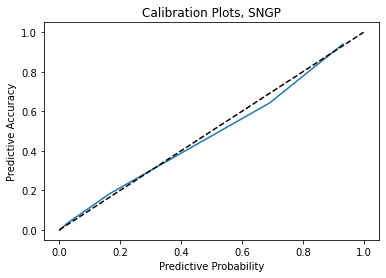

In [27]:
plt.plot(prob_pred, prob_true)

plt.plot([0., 1.], [0., 1.], c='k', linestyle="--")
plt.xlabel('Predictive Probability')
plt.ylabel('Predictive Accuracy')
plt.title('Calibration Plots, SNGP')

plt.show()

## Resources and further reading

* See the [SNGP tutorial](https://www.tensorflow.org/tutorials/understanding/sngp) for an detailed walkthrough of implementing SNGP from scratch. 
* See [Uncertainty Baselines](https://github.com/google/uncertainty-baselines)  for the implementation of SNGP model (and many other uncertainty methods) on a wide variety of benchmark datasets (e.g., [CIFAR](https://www.tensorflow.org/datasets/catalog/cifar100), [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012), [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), etc).
* For a deeper understanding of the SNGP method, check out the paper [Simple and Principled Uncertainty Estimation with Deterministic Deep Learning via Distance Awareness](https://arxiv.org/abs/2006.10108).
